# 🛡️ IDS Intelligent - Autoencoder Deep Learning pour Détection d'Intrusions
## **Network Intrusion Detection System basé sur Autoencoder + Classifier**

---

### 📋 **Informations du Projet**
| Élément | Détail |
|---------|--------|
| **Dataset** | CICIDS2017 (Canadian Institute for Cybersecurity) |
| **Architecture** | Autoencoder + Classifier Hybride |
| **Objectif** | Détection d'intrusions réseau en temps réel |
| **Sortie** | Format JSON structuré pour intégration LLM |
| **Version** | 1.0.0 |
| **Date** | Décembre 2024 |

---

### 🎯 **Objectifs du Notebook**
1. **Exploration** complète du dataset CICIDS2017
2. **Prétraitement** avec équilibrage par sous-échantillonnage stratifié
3. **Implémentation** de l'architecture Autoencoder + Classifier
4. **Entraînement** avec bonnes pratiques (Early Stopping, Focal Loss)
5. **Évaluation** avec métriques adaptées à la cybersécurité
6. **Export** du modèle pour production avec interface LLM

---

### ⚠️ **Bonnes Pratiques Cybersécurité**
- ✅ Détection des anomalies via reconstruction error
- ✅ Multi-classification des types d'attaques
- ✅ Métriques orientées sécurité (Detection Rate, False Positive Rate)
- ✅ Sortie structurée pour analyse par LLM/SOC
- ✅ Logging et traçabilité complète

## 📦 PARTIE 1: Configuration et Imports
Installation des dépendances et configuration de l'environnement.

In [24]:
# ============================================================================
# 1.1 INSTALLATION DES DÉPENDANCES
# ============================================================================
# Exécuter cette cellule uniquement si les packages ne sont pas installés

import subprocess
import sys

def install_if_missing(package, import_name=None):
    """Installe un package s'il n'est pas disponible."""
    import_name = import_name or package
    try:
        __import__(import_name)
        print(f"✅ {package} déjà installé")
    except ImportError:
        print(f"📦 Installation de {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✅ {package} installé avec succès")

# Packages requis
packages = [
    ("torch", "torch"),
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("scikit-learn", "sklearn"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("imbalanced-learn", "imblearn"),
    ("joblib", "joblib"),
    ("tqdm", "tqdm"),
]

print("🔧 Vérification des dépendances...\n")
for pkg, imp in packages:
    install_if_missing(pkg, imp)
print("\n✅ Toutes les dépendances sont prêtes!")

🔧 Vérification des dépendances...

✅ torch déjà installé
✅ pandas déjà installé
✅ numpy déjà installé
✅ scikit-learn déjà installé
✅ matplotlib déjà installé
✅ seaborn déjà installé
✅ imbalanced-learn déjà installé
✅ joblib déjà installé
✅ tqdm déjà installé

✅ Toutes les dépendances sont prêtes!


In [25]:
# ============================================================================
# 1.2 IMPORTS PRINCIPAUX
# ============================================================================

# === Data Processing ===
import pandas as pd
import numpy as np
from collections import Counter

# === Machine Learning ===
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, roc_auc_score, roc_curve,
    f1_score, precision_score, recall_score, accuracy_score,
    matthews_corrcoef, average_precision_score
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# === Deep Learning (PyTorch) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Utilities ===
import joblib
import json
import os
import time
import warnings
from datetime import datetime
from dataclasses import dataclass, asdict, field
from typing import List, Dict, Optional, Tuple
from tqdm.auto import tqdm

# === Configuration ===
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Seed pour reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'='*70}")
print(f"🖥️  CONFIGURATION SYSTÈME")
print(f"{'='*70}")
print(f"• PyTorch Version: {torch.__version__}")
print(f"• Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"• GPU: {torch.cuda.get_device_name(0)}")
    print(f"• CUDA Version: {torch.version.cuda}")
print(f"• Random State: {RANDOM_STATE}")
print(f"{'='*70}")

🖥️  CONFIGURATION SYSTÈME
• PyTorch Version: 2.9.1+cpu
• Device: cpu
• Random State: 42


In [26]:
# ============================================================================
# 1.3 CONFIGURATION GLOBALE DU PROJET
# ============================================================================

@dataclass
class Config:
    """Configuration centralisée du projet IDS."""
    
    # === Paths ===
    data_path: str = 'dataset/cicids2017_cleaned.csv'
    model_dir: str = 'models'
    results_dir: str = 'results'
    
    # === Model Architecture ===
    input_dim: int = 52  # Sera mis à jour après chargement
    latent_dim: int = 16
    hidden_dims: List[int] = field(default_factory=lambda: [128, 64, 32])
    num_classes: int = 7  # Sera mis à jour après chargement
    dropout: float = 0.3
    
    # === Training ===
    batch_size: int = 256
    epochs: int = 100
    learning_rate: float = 1e-3
    weight_decay: float = 1e-4
    patience: int = 15  # Early stopping
    
    # === Data ===
    test_size: float = 0.15
    val_size: float = 0.15
    undersample_ratio: float = 0.3  # Ratio pour sous-échantillonnage
    
    # === Loss === CORRIGÉ: réduire le poids de la reconstruction
    focal_gamma: float = 2.0  # Réduit de 2.5 à 2.0
    recon_weight: float = 0.1  # RÉDUIT de 0.3 à 0.1 (reconstruction explose)
    class_weight: float = 0.9  # AUGMENTÉ de 0.7 à 0.9 (priorité classification)
    
    # === Cybersecurity Thresholds ===
    anomaly_threshold: float = 0.5
    high_confidence_threshold: float = 0.85
    
    # === Version ===
    model_version: str = "1.1.0"  # Version mise à jour
    
    def __post_init__(self):
        """Crée les répertoires nécessaires."""
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)

# Initialisation de la configuration
config = Config()
print("✅ Configuration initialisée")
print(f"   • Modèle: Autoencoder IDS v{config.model_version}")
print(f"   • Batch Size: {config.batch_size}")
print(f"   • Learning Rate: {config.learning_rate}")
print(f"   • Epochs: {config.epochs}")
print(f"   • Loss weights: Classification={config.class_weight}, Reconstruction={config.recon_weight}")

✅ Configuration initialisée
   • Modèle: Autoencoder IDS v1.1.0
   • Batch Size: 256
   • Learning Rate: 0.001
   • Epochs: 100
   • Loss weights: Classification=0.9, Reconstruction=0.1


## 📊 PARTIE 2: Chargement et Exploration du Dataset
Analyse complète du dataset CICIDS2017 pour comprendre sa structure et ses caractéristiques.

In [27]:
# ============================================================================
# 2.1 CHARGEMENT DU DATASET
# ============================================================================

print(f"{'='*70}")
print("📂 CHARGEMENT DU DATASET CICIDS2017")
print(f"{'='*70}\n")

# Chargement
df = pd.read_csv(config.data_path)

print(f"✅ Dataset chargé avec succès!")
print(f"\n📋 INFORMATIONS GÉNÉRALES:")
print(f"   • Nombre de flux (samples): {df.shape[0]:,}")
print(f"   • Nombre de features: {df.shape[1]}")
print(f"   • Taille en mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Identification des colonnes
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 TYPES DE COLONNES:")
print(f"   • Colonnes numériques: {len(numeric_cols)}")
print(f"   • Colonnes catégorielles: {len(categorical_cols)}")

# Détection automatique de la colonne cible
if categorical_cols:
    label_col = categorical_cols[-1]  # Généralement la dernière colonne catégorielle
else:
    label_col = df.columns[-1]

print(f"\n🎯 Colonne cible détectée: '{label_col}'")

📂 CHARGEMENT DU DATASET CICIDS2017

✅ Dataset chargé avec succès!

📋 INFORMATIONS GÉNÉRALES:
   • Nombre de flux (samples): 2,520,751
   • Nombre de features: 53
   • Taille en mémoire: 1148.11 MB

📊 TYPES DE COLONNES:
   • Colonnes numériques: 52
   • Colonnes catégorielles: 1

🎯 Colonne cible détectée: 'Attack Type'


In [28]:
# ============================================================================
# 2.2 ANALYSE DES CLASSES (TYPES D'ATTAQUES)
# ============================================================================

print(f"{'='*70}")
print("🎯 DISTRIBUTION DES CLASSES")
print(f"{'='*70}\n")

# Distribution des classes
class_dist = df[label_col].value_counts()
class_pct = df[label_col].value_counts(normalize=True) * 100

# Affichage formaté
print(f"{'Classe':<20} {'Count':>12} {'Pourcentage':>12}")
print("-" * 46)
for cls in class_dist.index:
    print(f"{cls:<20} {class_dist[cls]:>12,} {class_pct[cls]:>11.2f}%")
print("-" * 46)
print(f"{'TOTAL':<20} {class_dist.sum():>12,} {'100.00':>11}%")

# Calcul du déséquilibre
imbalance_ratio = class_dist.max() / class_dist.min()
print(f"\n⚠️  ANALYSE DU DÉSÉQUILIBRE:")
print(f"   • Classe majoritaire: {class_dist.idxmax()} ({class_dist.max():,} samples)")
print(f"   • Classe minoritaire: {class_dist.idxmin()} ({class_dist.min():,} samples)")
print(f"   • Ratio d'imbalance: {imbalance_ratio:.1f}:1")

if imbalance_ratio > 100:
    print(f"\n   🔴 DÉSÉQUILIBRE CRITIQUE - Sous-échantillonnage recommandé")
elif imbalance_ratio > 10:
    print(f"\n   🟡 DÉSÉQUILIBRE MODÉRÉ - Class weights recommandés")
else:
    print(f"\n   🟢 DÉSÉQUILIBRE ACCEPTABLE")

🎯 DISTRIBUTION DES CLASSES

Classe                      Count  Pourcentage
----------------------------------------------
Normal Traffic          2,095,057       83.11%
DoS                       193,745        7.69%
DDoS                      128,014        5.08%
Port Scanning              90,694        3.60%
Brute Force                 9,150        0.36%
Web Attacks                 2,143        0.09%
Bots                        1,948        0.08%
----------------------------------------------
TOTAL                   2,520,751      100.00%

⚠️  ANALYSE DU DÉSÉQUILIBRE:
   • Classe majoritaire: Normal Traffic (2,095,057 samples)
   • Classe minoritaire: Bots (1,948 samples)
   • Ratio d'imbalance: 1075.5:1

   🔴 DÉSÉQUILIBRE CRITIQUE - Sous-échantillonnage recommandé


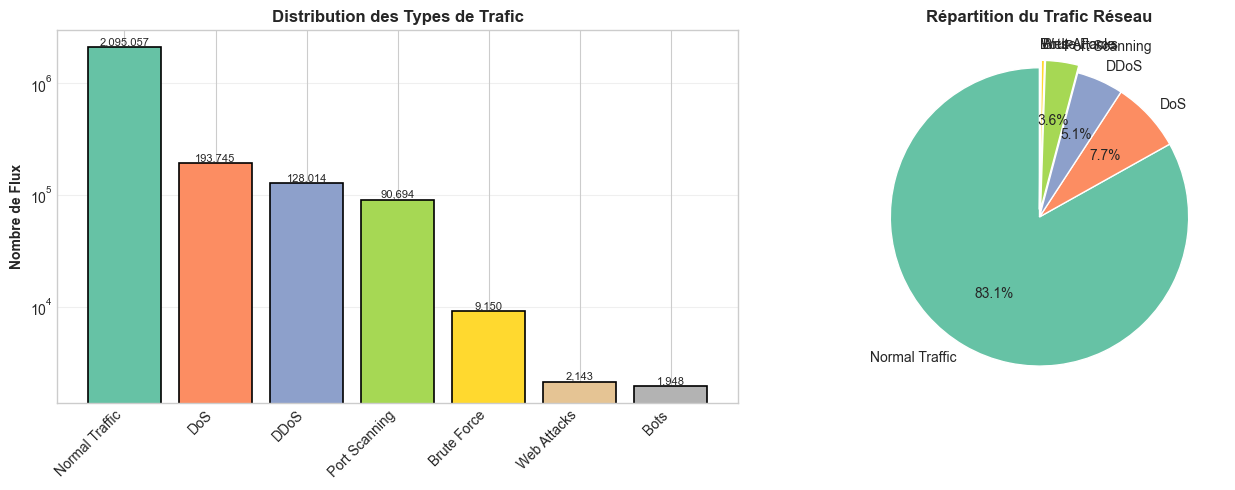


✅ Graphique sauvegardé: results/class_distribution.png


In [29]:
# ============================================================================
# 2.3 VISUALISATION DE LA DISTRIBUTION DES CLASSES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = plt.cm.Set2(np.linspace(0, 1, len(class_dist)))
bars = axes[0].bar(range(len(class_dist)), class_dist.values, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_xticks(range(len(class_dist)))
axes[0].set_xticklabels(class_dist.index, rotation=45, ha='right')
axes[0].set_ylabel('Nombre de Flux', fontweight='bold')
axes[0].set_title('Distribution des Types de Trafic', fontweight='bold', fontsize=12)
axes[0].set_yscale('log')  # Échelle log pour mieux voir les classes minoritaires
axes[0].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, val in zip(bars, class_dist.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,}', 
                 ha='center', va='bottom', fontsize=8, rotation=0)

# Pie chart
explode = [0.05 if pct < 5 else 0 for pct in class_pct.values]
wedges, texts, autotexts = axes[1].pie(
    class_dist.values, 
    labels=class_dist.index, 
    autopct=lambda p: f'{p:.1f}%' if p > 1 else '',
    startangle=90,
    explode=explode,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
axes[1].set_title('Répartition du Trafic Réseau', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(f'{config.results_dir}/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✅ Graphique sauvegardé: {config.results_dir}/class_distribution.png")

In [30]:
# ============================================================================
# 2.4 ANALYSE DES FEATURES
# ============================================================================

print(f"{'='*70}")
print("📈 ANALYSE DES FEATURES")
print(f"{'='*70}\n")

# Statistiques descriptives
print("📊 STATISTIQUES DESCRIPTIVES (échantillon):")
print(df[numeric_cols[:10]].describe().round(2).to_string())

# Valeurs manquantes
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0]

print(f"\n❓ VALEURS MANQUANTES:")
if len(missing_df) == 0:
    print("   ✅ Aucune valeur manquante détectée!")
else:
    for col, row in missing_df.iterrows():
        print(f"   • {col}: {row['Missing']:,} ({row['Percentage']:.2f}%)")

# Valeurs infinies
inf_count = np.isinf(df[numeric_cols]).sum().sum()
print(f"\n♾️  VALEURS INFINIES: {inf_count}")

# Doublons
duplicates = df.duplicated().sum()
print(f"\n🔄 DOUBLONS: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

📈 ANALYSE DES FEATURES

📊 STATISTIQUES DESCRIPTIVES (échantillon):
       Destination Port  Flow Duration  Total Fwd Packets  Total Length of Fwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min
count        2520751.00   2.520751e+06         2520751.00                   2520751.00             2520751.00              2520751.0              2520751.00             2520751.00             2520751.00             2520751.00
mean            8690.74   1.659032e+07              10.26                       606.52                 231.20                   19.2                   63.50                  77.32                 974.93                  43.16
std            19012.94   3.523140e+07             794.38                     10115.95                 756.31                   60.8                  195.55                 296.88                2038.15                  70.88
min                0.00  -1.3

In [31]:
# ============================================================================
# 2.5 ANALYSE DE CORRÉLATION ET SÉLECTION DE FEATURES
# ============================================================================

print(f"{'='*70}")
print("🔗 ANALYSE DE CORRÉLATION")
print(f"{'='*70}\n")

# Calcul de la matrice de corrélation (sur échantillon pour performance)
sample_size = min(50000, len(df))
sample_df = df[numeric_cols].sample(sample_size, random_state=RANDOM_STATE)
corr_matrix = sample_df.corr()

# Identification des features hautement corrélées
def find_redundant_features(corr_matrix, threshold=0.95):
    """Identifie les features redondantes basées sur la corrélation."""
    redundant = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                redundant.add(corr_matrix.columns[j])
    return redundant

redundant_features = find_redundant_features(corr_matrix, threshold=0.95)

print(f"📊 Features avec corrélation > 0.95: {len(redundant_features)}")
if redundant_features:
    print(f"   Features à considérer pour suppression:")
    for feat in list(redundant_features)[:10]:
        print(f"   • {feat}")
    if len(redundant_features) > 10:
        print(f"   ... et {len(redundant_features) - 10} autres")

# Features à garder
selected_features = [col for col in numeric_cols if col not in redundant_features]
print(f"\n✅ Features sélectionnées: {len(selected_features)}/{len(numeric_cols)}")

🔗 ANALYSE DE CORRÉLATION

📊 Features avec corrélation > 0.95: 15
   Features à considérer pour suppression:
   • Fwd IAT Max
   • Bwd Header Length
   • Idle Mean
   • Idle Max
   • Bwd Packet Length Mean
   • Fwd Packets/s
   • Bwd Packet Length Std
   • Fwd Header Length
   • act_data_pkt_fwd
   • Packet Length Std
   ... et 5 autres

✅ Features sélectionnées: 37/52


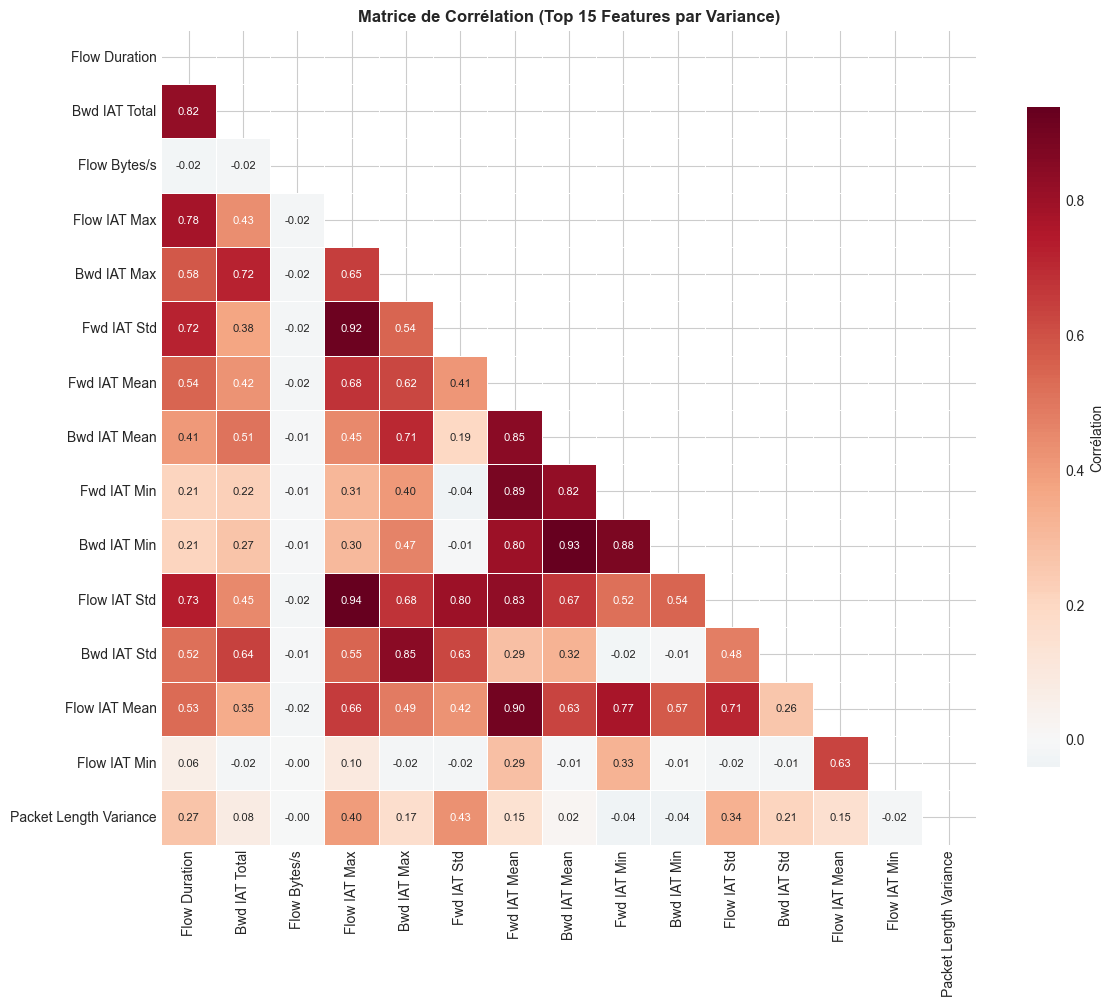


✅ Heatmap sauvegardée: results/correlation_heatmap.png


In [32]:
# ============================================================================
# 2.6 HEATMAP DE CORRÉLATION
# ============================================================================

# Sélection des top features par variance pour la heatmap
variance = df[selected_features].var().sort_values(ascending=False)
top_features_for_heatmap = variance.head(15).index.tolist()

fig, ax = plt.subplots(figsize=(12, 10))
corr_subset = df[top_features_for_heatmap].corr()

mask = np.triu(np.ones_like(corr_subset, dtype=bool))
sns.heatmap(
    corr_subset, 
    mask=mask,
    annot=True, 
    fmt='.2f', 
    cmap='RdBu_r', 
    center=0, 
    square=True, 
    ax=ax,
    cbar_kws={"shrink": 0.8, "label": "Corrélation"},
    annot_kws={"size": 8},
    linewidths=0.5
)
ax.set_title('Matrice de Corrélation (Top 15 Features par Variance)', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig(f'{config.results_dir}/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✅ Heatmap sauvegardée: {config.results_dir}/correlation_heatmap.png")

## ⚖️ PARTIE 3: Prétraitement et Équilibrage des Données
Gestion du déséquilibre critique via **sous-échantillonnage stratifié** - la méthode recommandée pour ce type de dataset.

In [33]:
# ============================================================================
# 3.1 PRÉPARATION DES DONNÉES
# ============================================================================

print(f"{'='*70}")
print("⚙️  PRÉPARATION DES DONNÉES")
print(f"{'='*70}\n")

# Utiliser les features sélectionnées (sans les redondantes)
feature_cols = selected_features.copy()

# Préparation X et y
X = df[feature_cols].copy()
y = df[label_col].copy()

# Gestion des valeurs infinies et NaN
print("🔧 Nettoyage des données...")
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n📊 ENCODAGE DES CLASSES:")
class_mapping = {}
for i, cls in enumerate(label_encoder.classes_):
    class_mapping[i] = cls
    count = (y_encoded == i).sum()
    print(f"   {i} → {cls:<15} ({count:,} samples)")

# Mise à jour de la configuration
config.input_dim = len(feature_cols)
config.num_classes = len(label_encoder.classes_)

print(f"\n✅ Données préparées:")
print(f"   • Features: {config.input_dim}")
print(f"   • Classes: {config.num_classes}")
print(f"   • Samples: {len(X):,}")

⚙️  PRÉPARATION DES DONNÉES

🔧 Nettoyage des données...

📊 ENCODAGE DES CLASSES:
   0 → Bots            (1,948 samples)
   1 → Brute Force     (9,150 samples)
   2 → DDoS            (128,014 samples)
   3 → DoS             (193,745 samples)
   4 → Normal Traffic  (2,095,057 samples)
   5 → Port Scanning   (90,694 samples)
   6 → Web Attacks     (2,143 samples)

✅ Données préparées:
   • Features: 37
   • Classes: 7
   • Samples: 2,520,751


In [34]:
# ============================================================================
# 3.2 SOUS-ÉCHANTILLONNAGE STRATIFIÉ INTELLIGENT
# ============================================================================
# 
# POURQUOI LE SOUS-ÉCHANTILLONNAGE?
# ---------------------------------
# Avec un ratio d'imbalance de ~1000:1, le sur-échantillonnage (SMOTE) créerait
# trop de données synthétiques et risquerait l'overfitting.
# Le sous-échantillonnage est la bonne pratique pour:
# - Réduire le temps d'entraînement
# - Éviter le biais vers la classe majoritaire
# - Garder des données réelles (pas synthétiques)
#
# STRATÉGIE:
# - Conserver TOUTES les classes minoritaires
# - Sous-échantillonner la classe majoritaire (Normal)
# - Objectif: ratio maximum de 10:1

print(f"{'='*70}")
print("⚖️  SOUS-ÉCHANTILLONNAGE STRATIFIÉ")
print(f"{'='*70}\n")

def smart_undersample(X, y, max_ratio=10, min_samples_per_class=1000):
    """
    Sous-échantillonnage intelligent préservant les classes minoritaires.
    
    Args:
        X: Features
        y: Labels encodés
        max_ratio: Ratio maximum entre classe majoritaire et minoritaire
        min_samples_per_class: Minimum de samples par classe
    
    Returns:
        X_resampled, y_resampled
    """
    class_counts = Counter(y)
    min_class_count = min(class_counts.values())
    
    # Calculer le nombre cible pour chaque classe
    target_counts = {}
    for cls, count in class_counts.items():
        if count > min_class_count * max_ratio:
            # Sous-échantillonner
            target_counts[cls] = max(min_class_count * max_ratio, min_samples_per_class)
        else:
            # Garder tel quel
            target_counts[cls] = count
    
    # Appliquer le sous-échantillonnage
    undersampler = RandomUnderSampler(
        sampling_strategy=target_counts,
        random_state=RANDOM_STATE
    )
    
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    
    return X_resampled, y_resampled

# Appliquer le sous-échantillonnage
print("📉 Distribution AVANT sous-échantillonnage:")
for cls in sorted(Counter(y_encoded).keys()):
    count = Counter(y_encoded)[cls]
    print(f"   {class_mapping[cls]:<15}: {count:>10,}")

X_resampled, y_resampled = smart_undersample(
    X.values, y_encoded, 
    max_ratio=10, 
    min_samples_per_class=1000
)

print(f"\n📊 Distribution APRÈS sous-échantillonnage:")
new_counts = Counter(y_resampled)
for cls in sorted(new_counts.keys()):
    count = new_counts[cls]
    print(f"   {class_mapping[cls]:<15}: {count:>10,}")

new_ratio = max(new_counts.values()) / min(new_counts.values())
print(f"\n✅ Nouveau ratio d'imbalance: {new_ratio:.1f}:1")
print(f"   Réduction: {len(y_encoded):,} → {len(y_resampled):,} samples ({len(y_resampled)/len(y_encoded)*100:.1f}%)")

⚖️  SOUS-ÉCHANTILLONNAGE STRATIFIÉ

📉 Distribution AVANT sous-échantillonnage:
   Bots           :      1,948
   Brute Force    :      9,150
   DDoS           :    128,014
   DoS            :    193,745
   Normal Traffic :  2,095,057
   Port Scanning  :     90,694
   Web Attacks    :      2,143

📊 Distribution APRÈS sous-échantillonnage:
   Bots           :      1,948
   Brute Force    :      9,150
   DDoS           :     19,480
   DoS            :     19,480
   Normal Traffic :     19,480
   Port Scanning  :     19,480
   Web Attacks    :      2,143

✅ Nouveau ratio d'imbalance: 10.0:1
   Réduction: 2,520,751 → 91,161 samples (3.6%)


In [35]:
# ============================================================================
# 3.3 SPLIT TRAIN/VALIDATION/TEST STRATIFIÉ
# ============================================================================

print(f"{'='*70}")
print("📂 DIVISION DES DONNÉES")
print(f"{'='*70}\n")

# Premier split: séparer le test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=config.test_size,
    stratify=y_resampled,
    random_state=RANDOM_STATE
)

# Deuxième split: séparer train et validation
val_ratio = config.val_size / (1 - config.test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print(f"📊 RÉPARTITION DES DONNÉES:")
print(f"   • Train:      {len(X_train):>8,} samples ({len(X_train)/len(X_resampled)*100:.1f}%)")
print(f"   • Validation: {len(X_val):>8,} samples ({len(X_val)/len(X_resampled)*100:.1f}%)")
print(f"   • Test:       {len(X_test):>8,} samples ({len(X_test)/len(X_resampled)*100:.1f}%)")

# Vérification de la stratification
print(f"\n📈 VÉRIFICATION DE LA STRATIFICATION:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    counts = Counter(y_split)
    total = len(y_split)
    print(f"\n   {split_name}:")
    for cls in sorted(counts.keys()):
        pct = counts[cls] / total * 100
        print(f"     {class_mapping[cls]:<15}: {counts[cls]:>6} ({pct:>5.1f}%)")

📂 DIVISION DES DONNÉES

📊 RÉPARTITION DES DONNÉES:
   • Train:        63,812 samples (70.0%)
   • Validation:   13,674 samples (15.0%)
   • Test:         13,675 samples (15.0%)

📈 VÉRIFICATION DE LA STRATIFICATION:

   Train:
     Bots           :   1364 (  2.1%)
     Brute Force    :   6404 ( 10.0%)
     DDoS           :  13636 ( 21.4%)
     DoS            :  13636 ( 21.4%)
     Normal Traffic :  13636 ( 21.4%)
     Port Scanning  :  13636 ( 21.4%)
     Web Attacks    :   1500 (  2.4%)

   Val:
     Bots           :    292 (  2.1%)
     Brute Force    :   1373 ( 10.0%)
     DDoS           :   2922 ( 21.4%)
     DoS            :   2922 ( 21.4%)
     Normal Traffic :   2922 ( 21.4%)
     Port Scanning  :   2922 ( 21.4%)
     Web Attacks    :    321 (  2.3%)

   Test:
     Bots           :    292 (  2.1%)
     Brute Force    :   1373 ( 10.0%)
     DDoS           :   2922 ( 21.4%)
     DoS            :   2922 ( 21.4%)
     Normal Traffic :   2922 ( 21.4%)
     Port Scanning  :   2922 ( 21

In [36]:
# ============================================================================
# 3.4 NORMALISATION DES FEATURES - VERSION CORRIGÉE
# ============================================================================

print(f"{'='*70}")
print("📏 NORMALISATION DES FEATURES")
print(f"{'='*70}\n")

# PROBLÈME IDENTIFIÉ: Les données ont des valeurs extrêmes (millions)
# SOLUTION: Utiliser StandardScaler + Clip des outliers extrêmes

# 1. D'abord, analyser les données brutes
print("📊 STATISTIQUES AVANT NORMALISATION:")
print(f"   • Mean: {np.mean(X_train):.2f}")
print(f"   • Std:  {np.std(X_train):.2f}")
print(f"   • Min:  {np.min(X_train):.2f}")
print(f"   • Max:  {np.max(X_train):.2f}")

# 2. Clipper les valeurs extrêmes (> 99.9 percentile)
# Cela évite que quelques outliers extrêmes détruisent la normalisation
percentile_99 = np.percentile(X_train, 99.9, axis=0)
percentile_01 = np.percentile(X_train, 0.1, axis=0)

X_train_clipped = np.clip(X_train, percentile_01, percentile_99)
X_val_clipped = np.clip(X_val, percentile_01, percentile_99)
X_test_clipped = np.clip(X_test, percentile_01, percentile_99)

print(f"\n🔧 Clipping appliqué (0.1% - 99.9% percentiles)")

# 3. Appliquer StandardScaler (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clipped)
X_val_scaled = scaler.transform(X_val_clipped)
X_test_scaled = scaler.transform(X_test_clipped)

print(f"\n📊 STATISTIQUES APRÈS NORMALISATION (Train):")
print(f"   • Mean:   {X_train_scaled.mean():.6f}")
print(f"   • Std:    {X_train_scaled.std():.6f}")
print(f"   • Min:    {X_train_scaled.min():.6f}")
print(f"   • Max:    {X_train_scaled.max():.6f}")

# Vérification que la normalisation est correcte
assert abs(X_train_scaled.mean()) < 0.01, "Mean should be ~0"
assert abs(X_train_scaled.std() - 1.0) < 0.1, "Std should be ~1"
print("\n✅ Normalisation vérifiée: Mean ≈ 0, Std ≈ 1")

# Sauvegarde du scaler et des percentiles pour production
scaler_path = f'{config.model_dir}/scaler.joblib'
percentiles_path = f'{config.model_dir}/percentiles.joblib'
joblib.dump(scaler, scaler_path)
joblib.dump({'p01': percentile_01, 'p99': percentile_99}, percentiles_path)
print(f"\n💾 Artefacts sauvegardés:")
print(f"   • {scaler_path}")
print(f"   • {percentiles_path}")

📏 NORMALISATION DES FEATURES

📊 STATISTIQUES AVANT NORMALISATION:
   • Mean: 2326061.92
   • Std:  12492314.82
   • Min:  -12.00
   • Max:  2071000000.00

🔧 Clipping appliqué (0.1% - 99.9% percentiles)

📊 STATISTIQUES APRÈS NORMALISATION (Train):
   • Mean:   0.000000
   • Std:    1.000000
   • Min:    -1.026136
   • Max:    24.756230

✅ Normalisation vérifiée: Mean ≈ 0, Std ≈ 1

💾 Artefacts sauvegardés:
   • models/scaler.joblib
   • models/percentiles.joblib


In [37]:
# ============================================================================
# 3.5 CRÉATION DES DATALOADERS PYTORCH
# ============================================================================

print(f"{'='*70}")
print("🔄 CRÉATION DES DATALOADERS")
print(f"{'='*70}\n")

# Conversion en tenseurs PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

# Création des datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Weighted Sampler pour gérer le déséquilibre résiduel
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size,
    sampler=sampler,  # Weighted sampling
    num_workers=0,
    pin_memory=True if DEVICE.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0
)

print(f"✅ DataLoaders créés:")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches:   {len(val_loader)}")
print(f"   • Test batches:  {len(test_loader)}")
print(f"   • Batch size:    {config.batch_size}")

🔄 CRÉATION DES DATALOADERS

✅ DataLoaders créés:
   • Train batches: 250
   • Val batches:   54
   • Test batches:  54
   • Batch size:    256


## 🧠 PARTIE 4: Architecture du Modèle - Autoencoder + Classifier
Implémentation de l'architecture hybride pour la détection d'anomalies et la classification multi-classes.

In [38]:
# ============================================================================
# 4.1 DÉFINITION DE L'ARCHITECTURE AUTOENCODER + CLASSIFIER
# ============================================================================

class AutoencoderIDS(nn.Module):
    """
    Architecture Autoencoder hybride pour la détection d'intrusions réseau.
    
    COMPOSANTS:
    -----------
    1. ENCODER: Compresse les features en un espace latent compact
       - Capture l'essence des patterns de trafic normal
       - Permet la détection d'anomalies via reconstruction error
    
    2. DECODER: Reconstruit les features originales
       - Les attaques (anomalies) auront une erreur de reconstruction élevée
       - Utilisé pour le calcul du score d'anomalie
    
    3. CLASSIFIER: Classification multi-classes sur l'espace latent + erreur
       - Combine les représentations latentes avec l'erreur de reconstruction
       - Permet une classification fine des types d'attaques
    
    AVANTAGES POUR LA CYBERSÉCURITÉ:
    ---------------------------------
    ✅ Double approche: anomalie (unsupervised) + classification (supervised)
    ✅ Robuste aux attaques zero-day (via reconstruction error)
    ✅ Interprétable: on peut analyser l'espace latent et l'erreur
    ✅ Adapté au temps réel: architecture légère
    """
    
    def __init__(
        self, 
        input_dim: int,
        latent_dim: int = 16,
        hidden_dims: List[int] = [128, 64, 32],
        num_classes: int = 7,
        dropout: float = 0.3
    ):
        super(AutoencoderIDS, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # ========================
        # ENCODER
        # ========================
        encoder_layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Couche latente finale
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # ========================
        # DECODER
        # ========================
        decoder_layers = []
        prev_dim = latent_dim
        
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Dropout(dropout * 0.5)  # Moins de dropout dans le decoder
            ])
            prev_dim = hidden_dim
        
        # Reconstruction finale
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
        # ========================
        # CLASSIFIER
        # ========================
        # Utilise l'espace latent + erreur de reconstruction comme features
        classifier_input = latent_dim + 1  # +1 pour la reconstruction error
        
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(32, num_classes)
        )
        
        # Initialisation des poids
        self._init_weights()
        
    def _init_weights(self):
        """Initialisation Xavier/Kaiming pour une meilleure convergence."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode les features dans l'espace latent."""
        return self.encoder(x)
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Décode l'espace latent vers les features originales."""
        return self.decoder(z)
    
    def compute_reconstruction_error(
        self, 
        x: torch.Tensor, 
        x_reconstructed: torch.Tensor
    ) -> torch.Tensor:
        """
        Calcule l'erreur de reconstruction (MSE par sample).
        Une erreur élevée indique une anomalie potentielle.
        """
        return torch.mean((x - x_reconstructed) ** 2, dim=1, keepdim=True)
    
    def forward(
        self, 
        x: torch.Tensor,
        return_all: bool = False
    ) -> Tuple[torch.Tensor, ...]:
        """
        Forward pass complet.
        
        Args:
            x: Input features (batch_size, input_dim)
            return_all: Si True, retourne tous les outputs intermédiaires
            
        Returns:
            class_logits: Logits de classification
            reconstructed: Features reconstruites (si return_all=True)
            latent: Représentation latente (si return_all=True)
            recon_error: Erreur de reconstruction (si return_all=True)
        """
        # Encode
        latent = self.encode(x)
        
        # Decode
        reconstructed = self.decode(latent)
        
        # Calcul de l'erreur de reconstruction
        recon_error = self.compute_reconstruction_error(x, reconstructed)
        
        # Classification: concat latent + erreur
        classifier_input = torch.cat([latent, recon_error], dim=1)
        class_logits = self.classifier(classifier_input)
        
        if return_all:
            return class_logits, reconstructed, latent, recon_error
        
        return class_logits, reconstructed, recon_error
    
    def get_anomaly_score(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calcule un score d'anomalie basé sur la reconstruction error.
        Score élevé = probable anomalie/attaque.
        """
        with torch.no_grad():
            latent = self.encode(x)
            reconstructed = self.decode(latent)
            recon_error = self.compute_reconstruction_error(x, reconstructed)
        return recon_error.squeeze()

# Afficher l'architecture
print(f"{'='*70}")
print("🧠 ARCHITECTURE DU MODÈLE")
print(f"{'='*70}\n")

model = AutoencoderIDS(
    input_dim=config.input_dim,
    latent_dim=config.latent_dim,
    hidden_dims=config.hidden_dims,
    num_classes=config.num_classes,
    dropout=config.dropout
).to(DEVICE)

# Résumé de l'architecture
print(model)
print(f"\n📊 PARAMÈTRES:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   • Total: {total_params:,}")
print(f"   • Trainable: {trainable_params:,}")

🧠 ARCHITECTURE DU MODÈLE

AutoencoderIDS(
  (encoder): Sequential(
    (0): Linear(in_features=37, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2):

In [39]:
# ============================================================================
# 4.2 FOCAL LOSS - GESTION DU DÉSÉQUILIBRE RÉSIDUEL
# ============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss pour gérer le déséquilibre des classes.
    
    La Focal Loss réduit l'importance des exemples faciles (bien classifiés)
    et se concentre sur les exemples difficiles (mal classifiés).
    
    Formule: FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    
    Paramètres:
    -----------
    alpha: Poids par classe (optionnel)
    gamma: Facteur de focus (défaut: 2.0)
           - gamma=0: équivalent à CrossEntropyLoss
           - gamma>0: réduit l'importance des exemples faciles
    """
    
    def __init__(
        self, 
        alpha: Optional[torch.Tensor] = None, 
        gamma: float = 2.0, 
        reduction: str = 'mean'
    ):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(
        self, 
        inputs: torch.Tensor, 
        targets: torch.Tensor
    ) -> torch.Tensor:
        """
        Args:
            inputs: Logits du modèle (batch_size, num_classes)
            targets: Labels (batch_size,)
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # Probabilité de la vraie classe
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
            
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss


class CombinedLoss(nn.Module):
    """
    Loss combinée pour l'Autoencoder IDS:
    - Reconstruction Loss (MSE): Pour la détection d'anomalies
    - Classification Loss (Focal): Pour la classification des attaques
    """
    
    def __init__(
        self,
        class_weights: Optional[torch.Tensor] = None,
        focal_gamma: float = 2.0,
        recon_weight: float = 0.3,
        class_weight: float = 0.7
    ):
        super(CombinedLoss, self).__init__()
        
        self.recon_weight = recon_weight
        self.class_weight = class_weight
        
        # Focal Loss pour la classification
        self.focal_loss = FocalLoss(alpha=class_weights, gamma=focal_gamma)
        
        # MSE Loss pour la reconstruction
        self.recon_loss = nn.MSELoss()
        
    def forward(
        self,
        class_logits: torch.Tensor,
        targets: torch.Tensor,
        x_original: torch.Tensor,
        x_reconstructed: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        Args:
            class_logits: Logits de classification
            targets: Labels
            x_original: Features originales
            x_reconstructed: Features reconstruites
            
        Returns:
            total_loss: Loss totale pondérée
            loss_dict: Dictionnaire des losses individuelles
        """
        # Classification loss
        cls_loss = self.focal_loss(class_logits, targets)
        
        # Reconstruction loss
        rec_loss = self.recon_loss(x_reconstructed, x_original)
        
        # Loss combinée
        total_loss = (self.class_weight * cls_loss) + (self.recon_weight * rec_loss)
        
        loss_dict = {
            'total': total_loss.item(),
            'classification': cls_loss.item(),
            'reconstruction': rec_loss.item()
        }
        
        return total_loss, loss_dict

# Calcul des poids de classes
class_counts_train = np.bincount(y_train)
class_weights_np = 1.0 / class_counts_train
class_weights_np = class_weights_np / class_weights_np.sum() * len(class_weights_np)  # Normalisation
class_weights_tensor = torch.FloatTensor(class_weights_np).to(DEVICE)

print(f"{'='*70}")
print("⚖️  POIDS DES CLASSES (pour Focal Loss)")
print(f"{'='*70}\n")
for i, (cls_name, weight) in enumerate(zip(label_encoder.classes_, class_weights_np)):
    print(f"   {cls_name:<15}: {weight:.4f}")

# Initialisation de la loss combinée
criterion = CombinedLoss(
    class_weights=class_weights_tensor,
    focal_gamma=config.focal_gamma,
    recon_weight=config.recon_weight,
    class_weight=config.class_weight
)

print(f"\n✅ Loss combinée configurée:")
print(f"   • Focal Gamma: {config.focal_gamma}")
print(f"   • Poids Classification: {config.class_weight}")
print(f"   • Poids Reconstruction: {config.recon_weight}")

⚖️  POIDS DES CLASSES (pour Focal Loss)

   Bots           : 2.7751
   Brute Force    : 0.5911
   DDoS           : 0.2776
   DoS            : 0.2776
   Normal Traffic : 0.2776
   Port Scanning  : 0.2776
   Web Attacks    : 2.5235

✅ Loss combinée configurée:
   • Focal Gamma: 2.0
   • Poids Classification: 0.9
   • Poids Reconstruction: 0.1


## 🚀 PARTIE 5: Entraînement du Modèle
Boucle d'entraînement avec Early Stopping, Learning Rate Scheduling, et logging détaillé.

In [40]:
# ============================================================================
# 5.1 CLASSE D'ENTRAÎNEMENT
# ============================================================================

class EarlyStopping:
    """
    Early Stopping pour éviter l'overfitting.
    Arrête l'entraînement si la validation loss ne s'améliore pas.
    """
    
    def __init__(self, patience: int = 10, min_delta: float = 0.001, mode: str = 'min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, score: float, model: nn.Module) -> bool:
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict().copy()
        elif self._is_improvement(score):
            self.best_score = score
            self.best_model_state = model.state_dict().copy()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop
    
    def _is_improvement(self, score: float) -> bool:
        if self.mode == 'min':
            return score < self.best_score - self.min_delta
        return score > self.best_score + self.min_delta
    
    def restore_best_model(self, model: nn.Module):
        """Restaure le meilleur modèle."""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)


class IDSTrainer:
    """
    Classe d'entraînement pour le modèle IDS.
    """
    
    def __init__(
        self,
        model: nn.Module,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
        device: torch.device = DEVICE,
        early_stopping: Optional[EarlyStopping] = None
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.early_stopping = early_stopping
        
        # Historique
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_f1': [], 'val_f1': [],
            'lr': []
        }
        
    def train_epoch(self, train_loader: DataLoader) -> Dict[str, float]:
        """Entraîne une époque."""
        self.model.train()
        total_loss = 0
        all_preds = []
        all_targets = []
        
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(self.device)
            batch_y = batch_y.to(self.device)
            
            # Forward
            self.optimizer.zero_grad()
            class_logits, reconstructed, _ = self.model(batch_x)
            
            # Loss
            loss, _ = self.criterion(class_logits, batch_y, batch_x, reconstructed)
            
            # Backward
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            preds = torch.argmax(class_logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
        
        # Métriques
        avg_loss = total_loss / len(train_loader)
        accuracy = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='weighted')
        
        return {'loss': avg_loss, 'accuracy': accuracy, 'f1': f1}
    
    @torch.no_grad()
    def validate(self, val_loader: DataLoader) -> Dict[str, float]:
        """Validation du modèle."""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_targets = []
        
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(self.device)
            batch_y = batch_y.to(self.device)
            
            class_logits, reconstructed, _ = self.model(batch_x)
            loss, _ = self.criterion(class_logits, batch_y, batch_x, reconstructed)
            
            total_loss += loss.item()
            preds = torch.argmax(class_logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
        
        avg_loss = total_loss / len(val_loader)
        accuracy = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='weighted')
        
        return {'loss': avg_loss, 'accuracy': accuracy, 'f1': f1}
    
    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        epochs: int,
        verbose: bool = True
    ) -> Dict[str, List[float]]:
        """Boucle d'entraînement complète."""
        
        best_val_f1 = 0
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # Train
            train_metrics = self.train_epoch(train_loader)
            
            # Validate
            val_metrics = self.validate(val_loader)
            
            # Learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Scheduler step
            if self.scheduler is not None:
                if isinstance(self.scheduler, ReduceLROnPlateau):
                    self.scheduler.step(val_metrics['loss'])
                else:
                    self.scheduler.step()
            
            # History
            self.history['train_loss'].append(train_metrics['loss'])
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['train_acc'].append(train_metrics['accuracy'])
            self.history['val_acc'].append(val_metrics['accuracy'])
            self.history['train_f1'].append(train_metrics['f1'])
            self.history['val_f1'].append(val_metrics['f1'])
            self.history['lr'].append(current_lr)
            
            # Early stopping
            if self.early_stopping is not None:
                if self.early_stopping(val_metrics['loss'], self.model):
                    if verbose:
                        print(f"\n⏹️  Early stopping à l'époque {epoch+1}")
                    break
            
            # Verbose
            if verbose and (epoch + 1) % 5 == 0:
                elapsed = time.time() - start_time
                print(f"Epoch {epoch+1:3d}/{epochs} | "
                      f"Train Loss: {train_metrics['loss']:.4f} | "
                      f"Val Loss: {val_metrics['loss']:.4f} | "
                      f"Val F1: {val_metrics['f1']:.4f} | "
                      f"LR: {current_lr:.6f} | "
                      f"Time: {elapsed:.1f}s")
        
        # Restaurer le meilleur modèle
        if self.early_stopping is not None:
            self.early_stopping.restore_best_model(self.model)
            
        return self.history

print("✅ Classes d'entraînement définies")

✅ Classes d'entraînement définies


In [41]:
# ============================================================================
# 5.2 CONFIGURATION ET LANCEMENT DE L'ENTRAÎNEMENT
# ============================================================================

print(f"{'='*70}")
print("🚀 LANCEMENT DE L'ENTRAÎNEMENT")
print(f"{'='*70}\n")

# Optimiseur AdamW (meilleur que Adam pour la régularisation)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    betas=(0.9, 0.999)
)

# Scheduler: ReduceLROnPlateau
# Note: 'verbose' a été supprimé dans les versions récentes de PyTorch
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Early Stopping
early_stopping = EarlyStopping(
    patience=config.patience,
    min_delta=0.001,
    mode='min'
)

# Trainer
trainer = IDSTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    early_stopping=early_stopping
)

print("📋 CONFIGURATION:")
print(f"   • Optimiseur: AdamW")
print(f"   • Learning Rate: {config.learning_rate}")
print(f"   • Weight Decay: {config.weight_decay}")
print(f"   • Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"   • Early Stopping: patience={config.patience}")
print(f"   • Epochs max: {config.epochs}")
print(f"\n{'='*70}")
print("📈 PROGRESSION DE L'ENTRAÎNEMENT")
print(f"{'='*70}\n")

# Entraînement
start_time = time.time()
history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=config.epochs,
    verbose=True
)
training_time = time.time() - start_time

print(f"\n{'='*70}")
print(f"✅ ENTRAÎNEMENT TERMINÉ")
print(f"   • Durée totale: {training_time/60:.1f} minutes")
print(f"   • Epochs effectués: {len(history['train_loss'])}")
print(f"   • Meilleure Val Loss: {min(history['val_loss']):.4f}")
print(f"   • Meilleur Val F1: {max(history['val_f1']):.4f}")
print(f"{'='*70}")

🚀 LANCEMENT DE L'ENTRAÎNEMENT

📋 CONFIGURATION:
   • Optimiseur: AdamW
   • Learning Rate: 0.001
   • Weight Decay: 0.0001
   • Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
   • Early Stopping: patience=15
   • Epochs max: 100

📈 PROGRESSION DE L'ENTRAÎNEMENT

Epoch   5/100 | Train Loss: 0.1286 | Val Loss: 0.0885 | Val F1: 0.8913 | LR: 0.001000 | Time: 6.4s
Epoch  10/100 | Train Loss: 0.0863 | Val Loss: 0.0586 | Val F1: 0.9199 | LR: 0.001000 | Time: 6.6s
Epoch  15/100 | Train Loss: 0.0720 | Val Loss: 0.0491 | Val F1: 0.9389 | LR: 0.001000 | Time: 7.8s
Epoch  20/100 | Train Loss: 0.0631 | Val Loss: 0.0438 | Val F1: 0.9454 | LR: 0.001000 | Time: 6.9s
Epoch  25/100 | Train Loss: 0.0576 | Val Loss: 0.0385 | Val F1: 0.9539 | LR: 0.001000 | Time: 7.3s
Epoch  30/100 | Train Loss: 0.0540 | Val Loss: 0.0350 | Val F1: 0.9565 | LR: 0.001000 | Time: 7.0s
Epoch  35/100 | Train Loss: 0.0500 | Val Loss: 0.0345 | Val F1: 0.9570 | LR: 0.001000 | Time: 4.4s
Epoch  40/100 | Train Loss: 0.0490 | 

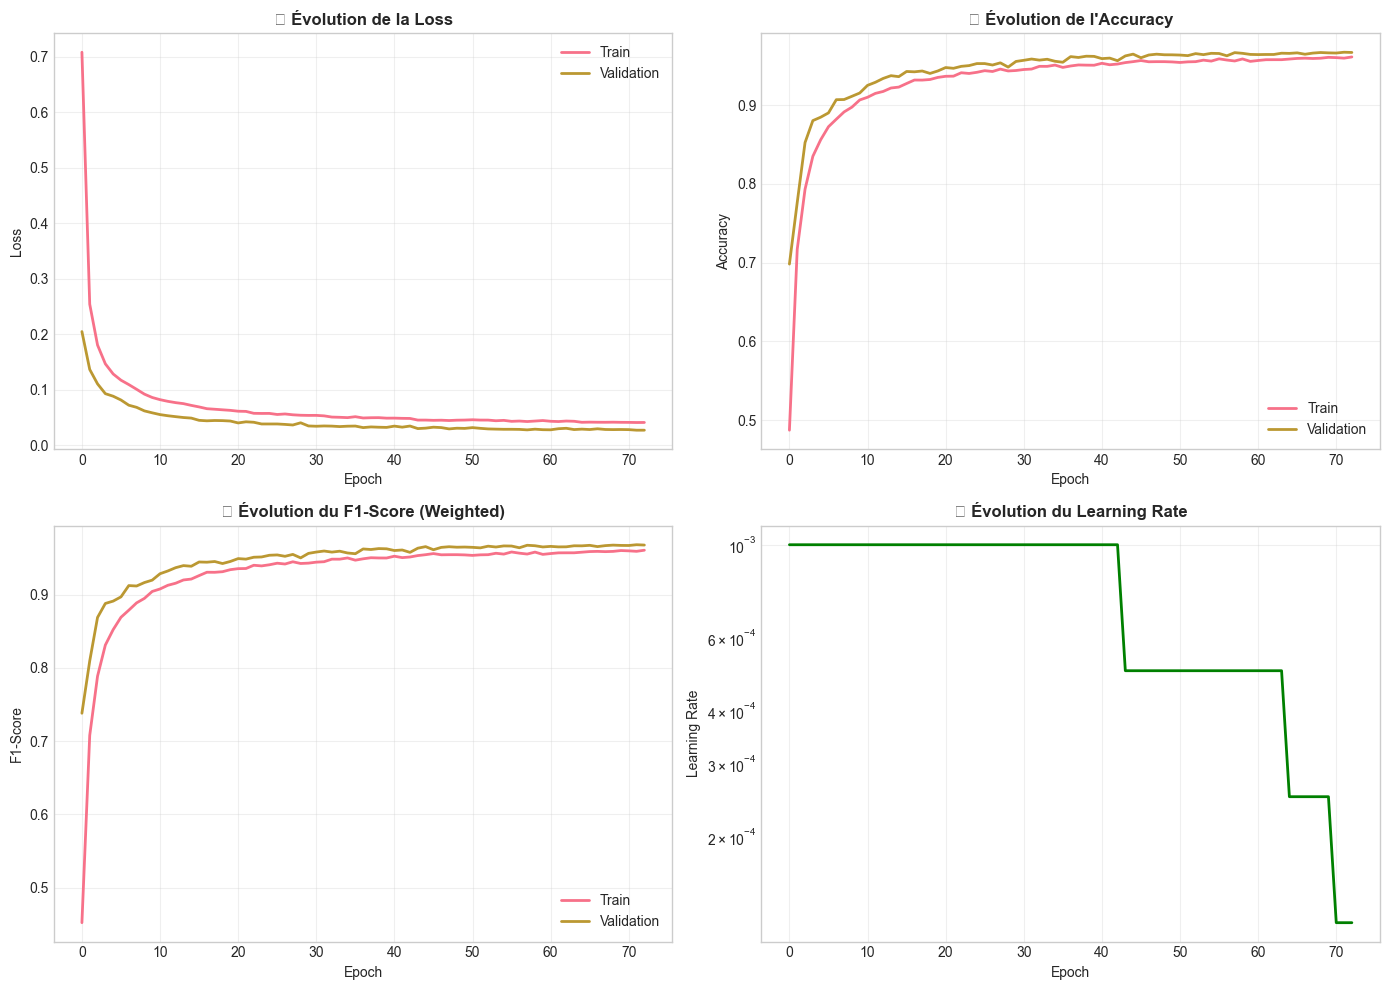


✅ Courbes d'entraînement sauvegardées: results/training_curves.png


In [49]:
# ============================================================================
# 5.3 VISUALISATION DE L'ENTRAÎNEMENT
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('📉 Évolution de la Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('📈 Évolution de l\'Accuracy', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
axes[1, 0].plot(history['train_f1'], label='Train', linewidth=2)
axes[1, 0].plot(history['val_f1'], label='Validation', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('📊 Évolution du F1-Score (Weighted)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history['lr'], linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('🔧 Évolution du Learning Rate', fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.results_dir}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✅ Courbes d'entraînement sauvegardées: {config.results_dir}/training_curves.png")

## 📊 PARTIE 6: Évaluation Complète du Modèle
Évaluation détaillée avec métriques spécifiques à la cybersécurité: Detection Rate, False Positive Rate, etc.

In [43]:
# ============================================================================
# 6.1 PRÉDICTIONS SUR LE JEU DE TEST
# ============================================================================

print(f"{'='*70}")
print("🧪 ÉVALUATION SUR LE JEU DE TEST")
print(f"{'='*70}\n")

model.eval()
all_preds = []
all_probs = []
all_targets = []
all_recon_errors = []
all_latents = []

with torch.no_grad():
    for batch_x, batch_y in tqdm(test_loader, desc="Évaluation"):
        batch_x = batch_x.to(DEVICE)
        
        # Forward complet
        class_logits, reconstructed, latent, recon_error = model(batch_x, return_all=True)
        
        # Probabilités
        probs = F.softmax(class_logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(batch_y.numpy())
        all_recon_errors.extend(recon_error.cpu().numpy().flatten())
        all_latents.extend(latent.cpu().numpy())

# Conversion en arrays
y_pred = np.array(all_preds)
y_proba = np.array(all_probs)
y_true = np.array(all_targets)
recon_errors = np.array(all_recon_errors)
latent_representations = np.array(all_latents)

print(f"✅ Prédictions générées: {len(y_pred):,} samples")

🧪 ÉVALUATION SUR LE JEU DE TEST



Évaluation: 100%|██████████| 54/54 [00:00<00:00, 238.49it/s]

✅ Prédictions générées: 13,675 samples


In [44]:
# ============================================================================
# 6.2 MÉTRIQUES GLOBALES
# ============================================================================

print(f"{'='*70}")
print("📊 MÉTRIQUES GLOBALES")
print(f"{'='*70}\n")

# Métriques de base
accuracy = accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

# ROC-AUC (multi-class)
try:
    roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
except:
    roc_auc = 0.0

print(f"┌{'─'*50}┐")
print(f"│{'MÉTRIQUE':<25}{'VALEUR':>24}│")
print(f"├{'─'*50}┤")
print(f"│{'Accuracy':<25}{accuracy:>23.4f}│")
print(f"│{'F1-Score (Weighted)':<25}{f1_weighted:>23.4f}│")
print(f"│{'F1-Score (Macro)':<25}{f1_macro:>23.4f}│")
print(f"│{'Precision (Weighted)':<25}{precision_weighted:>23.4f}│")
print(f"│{'Recall (Weighted)':<25}{recall_weighted:>23.4f}│")
print(f"│{'Matthews Corr. Coef.':<25}{mcc:>23.4f}│")
print(f"│{'ROC-AUC (Weighted)':<25}{roc_auc:>23.4f}│")
print(f"└{'─'*50}┘")

# Interprétation
print(f"\n📋 INTERPRÉTATION:")
if accuracy >= 0.95:
    print(f"   ✅ Excellente performance globale!")
elif accuracy >= 0.90:
    print(f"   🟢 Bonne performance, peut être améliorée")
else:
    print(f"   🟡 Performance à améliorer")
    
if f1_macro < f1_weighted - 0.1:
    print(f"   ⚠️  Écart F1 macro/weighted: certaines classes minoritaires moins bien détectées")

📊 MÉTRIQUES GLOBALES

┌──────────────────────────────────────────────────┐
│MÉTRIQUE                                   VALEUR│
├──────────────────────────────────────────────────┤
│Accuracy                                  0.9655│
│F1-Score (Weighted)                       0.9665│
│F1-Score (Macro)                          0.9280│
│Precision (Weighted)                      0.9712│
│Recall (Weighted)                         0.9655│
│Matthews Corr. Coef.                      0.9578│
│ROC-AUC (Weighted)                        0.9945│
└──────────────────────────────────────────────────┘

📋 INTERPRÉTATION:
   ✅ Excellente performance globale!


In [50]:
# ============================================================================
# 6.3 RAPPORT DE CLASSIFICATION DÉTAILLÉ
# ============================================================================

print(f"{'='*70}")
print("📋 RAPPORT DE CLASSIFICATION PAR CLASSE")
print(f"{'='*70}\n")

# Rapport sklearn
report = classification_report(
    y_true, y_pred,
    target_names=label_encoder.classes_,
    digits=4
)
print(report)

# Métriques spécifiques à la cybersécurité
print(f"\n{'='*70}")
print("🛡️  MÉTRIQUES CYBERSÉCURITÉ")
print(f"{'='*70}\n")

print(f"{'Classe':<15} {'Detection Rate':>15} {'FPR':>10} {'Support':>10}")
print("-" * 52)

for i, cls_name in enumerate(label_encoder.classes_):
    # True Positives, False Negatives, False Positives
    binary_true = (y_true == i).astype(int)
    binary_pred = (y_pred == i).astype(int)
    
    tp = np.sum((binary_true == 1) & (binary_pred == 1))
    fn = np.sum((binary_true == 1) & (binary_pred == 0))
    fp = np.sum((binary_true == 0) & (binary_pred == 1))
    tn = np.sum((binary_true == 0) & (binary_pred == 0))
    
    # Detection Rate (Recall / Sensitivity)
    detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # False Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Support
    support = np.sum(binary_true)
    
    # Indicateur visuel
    dr_indicator = "✅" if detection_rate >= 0.90 else "🟡" if detection_rate >= 0.80 else "🔴"
    
    print(f"{cls_name:<15} {detection_rate:>14.2%} {fpr:>9.4f} {support:>10,} {dr_indicator}")

📋 RAPPORT DE CLASSIFICATION PAR CLASSE

                precision    recall  f1-score   support

          Bots     0.7005    0.9932    0.8215       292
   Brute Force     0.9339    0.9680    0.9506      1373
          DDoS     0.9952    0.9983    0.9968      2922
           DoS     0.9841    0.9771    0.9806      2922
Normal Traffic     0.9962    0.8884    0.9392      2922
 Port Scanning     0.9837    0.9918    0.9877      2922
   Web Attacks     0.7004    0.9876    0.8196       322

      accuracy                         0.9655     13675
     macro avg     0.8992    0.9720    0.9280     13675
  weighted avg     0.9712    0.9655    0.9665     13675


🛡️  MÉTRIQUES CYBERSÉCURITÉ

Classe           Detection Rate        FPR    Support
----------------------------------------------------
Bots                    99.32%    0.0093        292 ✅
Brute Force             96.80%    0.0076      1,373 ✅
DDoS                    99.83%    0.0013      2,922 ✅
DoS                     97.71%    0.0043  

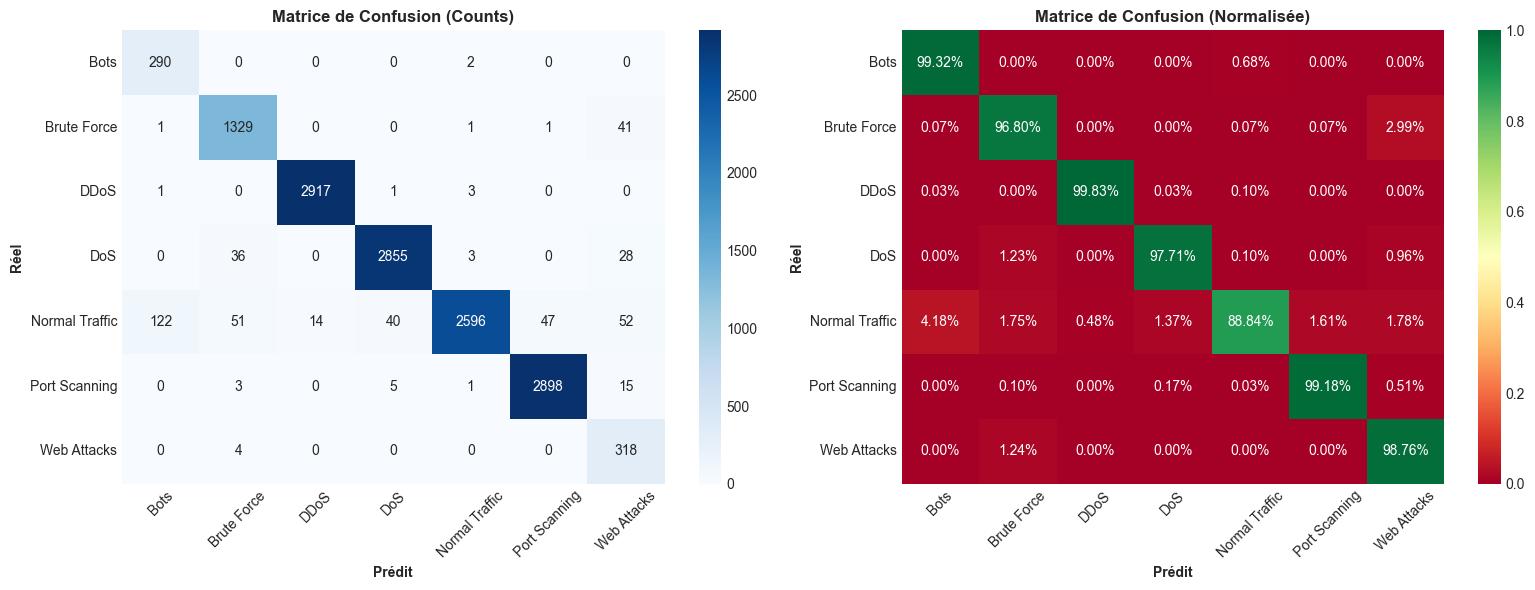


✅ Matrice de confusion sauvegardée: results/confusion_matrix.png


In [46]:
# ============================================================================
# 6.4 MATRICE DE CONFUSION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matrice de confusion standard
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    ax=axes[0]
)
axes[0].set_xlabel('Prédit', fontweight='bold')
axes[0].set_ylabel('Réel', fontweight='bold')
axes[0].set_title('Matrice de Confusion (Counts)', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Matrice de confusion normalisée
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2%', 
    cmap='RdYlGn',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    ax=axes[1],
    vmin=0, vmax=1
)
axes[1].set_xlabel('Prédit', fontweight='bold')
axes[1].set_ylabel('Réel', fontweight='bold')
axes[1].set_title('Matrice de Confusion (Normalisée)', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig(f'{config.results_dir}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✅ Matrice de confusion sauvegardée: {config.results_dir}/confusion_matrix.png")

🔍 ANALYSE DE LA RECONSTRUCTION ERROR (ANOMALY DETECTION)

Classe            Mean Error        Std     Median
--------------------------------------------------
Bots                0.041708   0.077395   0.016253
Brute Force         0.020316   0.047587   0.007662
DDoS                0.039149   0.066040   0.014889
DoS                 0.129294   0.384637   0.040101
Normal Traffic      0.239847   0.551214   0.079667
Port Scanning       0.045237   0.117789   0.008970
Web Attacks         0.018218   0.062827   0.001498


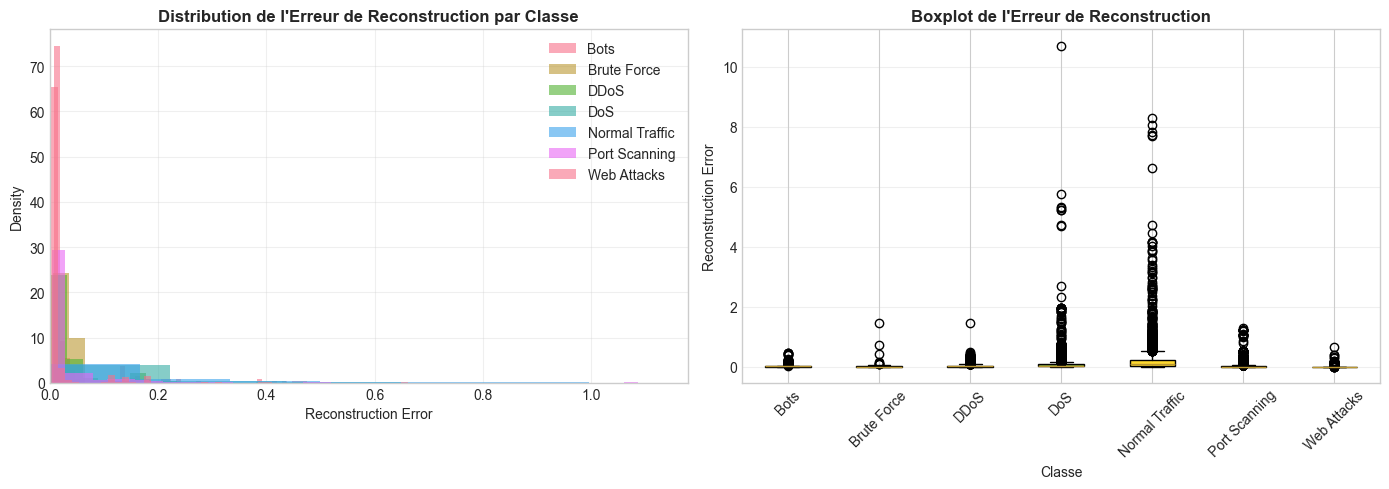


💡 INSIGHT: Une erreur de reconstruction plus élevée indique une anomalie potentielle.
   Les attaques devraient avoir une erreur moyenne plus élevée que le trafic Normal.


In [47]:
# ============================================================================
# 6.5 ANALYSE DE LA RECONSTRUCTION ERROR (ANOMALY SCORE)
# ============================================================================

print(f"{'='*70}")
print("🔍 ANALYSE DE LA RECONSTRUCTION ERROR (ANOMALY DETECTION)")
print(f"{'='*70}\n")

# Statistiques par classe
recon_by_class = {}
for i, cls_name in enumerate(label_encoder.classes_):
    mask = y_true == i
    recon_by_class[cls_name] = recon_errors[mask]

# Affichage des statistiques
print(f"{'Classe':<15} {'Mean Error':>12} {'Std':>10} {'Median':>10}")
print("-" * 50)
for cls_name, errors in recon_by_class.items():
    print(f"{cls_name:<15} {np.mean(errors):>12.6f} {np.std(errors):>10.6f} {np.median(errors):>10.6f}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution de l'erreur par classe
for cls_name, errors in recon_by_class.items():
    axes[0].hist(errors, bins=50, alpha=0.6, label=cls_name, density=True)
axes[0].set_xlabel('Reconstruction Error')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution de l\'Erreur de Reconstruction par Classe', fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(recon_errors, 99))
axes[0].grid(True, alpha=0.3)

# Boxplot
bp_data = [recon_by_class[cls] for cls in label_encoder.classes_]
bp = axes[1].boxplot(bp_data, labels=label_encoder.classes_, patch_artist=True)
for patch, color in zip(bp['boxes'], plt.cm.Set2(np.linspace(0, 1, len(label_encoder.classes_)))):
    patch.set_facecolor(color)
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Reconstruction Error')
axes[1].set_title('Boxplot de l\'Erreur de Reconstruction', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{config.results_dir}/reconstruction_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 INSIGHT: Une erreur de reconstruction plus élevée indique une anomalie potentielle.")
print(f"   Les attaques devraient avoir une erreur moyenne plus élevée que le trafic Normal.")

🔬 VISUALISATION DE L'ESPACE LATENT (t-SNE)

Application de t-SNE sur 5,000 samples...


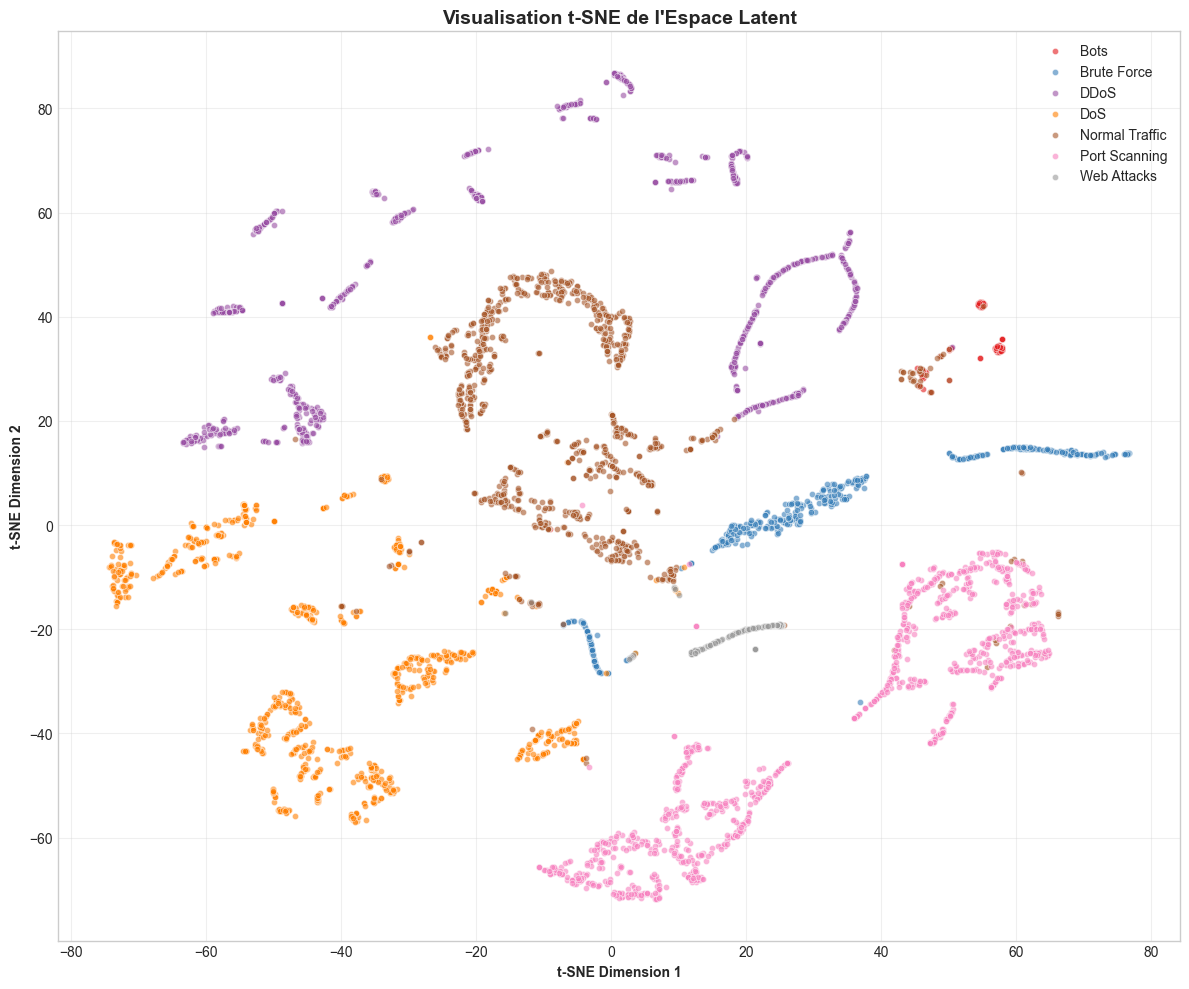


✅ Visualisation t-SNE sauvegardée: results/latent_space_tsne.png

💡 INTERPRÉTATION:
   • Des clusters bien séparés indiquent une bonne représentation latente
   • Les attaques similaires devraient être proches dans l'espace latent


In [51]:
# ============================================================================
# 6.6 VISUALISATION DE L'ESPACE LATENT
# ============================================================================

from sklearn.manifold import TSNE

print(f"{'='*70}")
print("🔬 VISUALISATION DE L'ESPACE LATENT (t-SNE)")
print(f"{'='*70}\n")

# t-SNE sur un échantillon (pour performance)
sample_size = min(5000, len(latent_representations))
indices = np.random.choice(len(latent_representations), sample_size, replace=False)
latent_sample = latent_representations[indices]
y_sample = y_true[indices]

print(f"Application de t-SNE sur {sample_size:,} samples...")
# Note: 'n_iter' renommé en 'max_iter' dans scikit-learn >= 1.5
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
latent_2d = tsne.fit_transform(latent_sample)

# Visualisation
fig, ax = plt.subplots(figsize=(12, 10))
colors = plt.cm.Set1(np.linspace(0, 1, config.num_classes))

for i, cls_name in enumerate(label_encoder.classes_):
    mask = y_sample == i
    ax.scatter(
        latent_2d[mask, 0], 
        latent_2d[mask, 1], 
        c=[colors[i]], 
        label=cls_name,
        alpha=0.6,
        s=20,
        edgecolors='white',
        linewidth=0.5
    )

ax.set_xlabel('t-SNE Dimension 1', fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontweight='bold')
ax.set_title('Visualisation t-SNE de l\'Espace Latent', fontweight='bold', fontsize=14)
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.results_dir}/latent_space_tsne.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualisation t-SNE sauvegardée: {config.results_dir}/latent_space_tsne.png")
print(f"\n💡 INTERPRÉTATION:")
print(f"   • Des clusters bien séparés indiquent une bonne représentation latente")
print(f"   • Les attaques similaires devraient être proches dans l'espace latent")

## 💾 PARTIE 7: Export du Modèle pour Production
Sauvegarde du modèle et de tous les artefacts nécessaires pour le déploiement en production.

In [54]:
# ============================================================================
# 7.1 SAUVEGARDE DU MODÈLE ET ARTEFACTS
# ============================================================================

print(f"{'='*70}")
print("💾 SAUVEGARDE DU MODÈLE POUR PRODUCTION")
print(f"{'='*70}\n")

# Timestamp pour le versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Sauvegarde du modèle PyTorch
model_path = f'{config.model_dir}/autoencoder_ids_v{config.model_version}.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': config.input_dim,
        'latent_dim': config.latent_dim,
        'hidden_dims': config.hidden_dims,
        'num_classes': config.num_classes,
        'dropout': config.dropout
    },
    'training_config': {
        'epochs_trained': len(history['train_loss']),
        'final_val_loss': history['val_loss'][-1],
        'final_val_f1': history['val_f1'][-1],
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate
    },
    'metrics': {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'mcc': mcc,
        'roc_auc': roc_auc
    },
    'timestamp': timestamp,
    'version': config.model_version
}, model_path)
print(f"✅ Modèle sauvegardé: {model_path}")

# 2. Sauvegarde du LabelEncoder
label_encoder_path = f'{config.model_dir}/label_encoder.joblib'
joblib.dump(label_encoder, label_encoder_path)
print(f"✅ LabelEncoder sauvegardé: {label_encoder_path}")

# 3. Sauvegarde des noms de features
feature_names_path = f'{config.model_dir}/feature_names.json'
with open(feature_names_path, 'w') as f:
    json.dump(feature_cols, f, indent=2)
print(f"✅ Feature names sauvegardés: {feature_names_path}")

# 4. Sauvegarde de la configuration complète
config_path = f'{config.model_dir}/model_config.json'
model_metadata = {
    'version': config.model_version,
    'timestamp': timestamp,
    'architecture': 'AutoencoderIDS',
    'input_dim': config.input_dim,
    'latent_dim': config.latent_dim,
    'hidden_dims': config.hidden_dims,
    'num_classes': config.num_classes,
    'class_names': list(label_encoder.classes_),
    'metrics': {
        'accuracy': float(accuracy),
        'f1_weighted': float(f1_weighted),
        'f1_macro': float(f1_macro),
        'mcc': float(mcc),
        'roc_auc': float(roc_auc)
    },
    'thresholds': {
        'anomaly': config.anomaly_threshold,
        'high_confidence': config.high_confidence_threshold
    }
}
with open(config_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✅ Configuration sauvegardée: {config_path}")

print(f"\n📁 ARTEFACTS SAUVEGARDÉS DANS: {config.model_dir}/")
print(f"   • autoencoder_ids_v{config.model_version}.pt")
print(f"   • scaler.joblib")
print(f"   • label_encoder.joblib")
print(f"   • feature_names.json")
print(f"   • model_config.json")

💾 SAUVEGARDE DU MODÈLE POUR PRODUCTION

✅ Modèle sauvegardé: models/autoencoder_ids_v1.1.0.pt
✅ LabelEncoder sauvegardé: models/label_encoder.joblib
✅ Feature names sauvegardés: models/feature_names.json
✅ Configuration sauvegardée: models/model_config.json

📁 ARTEFACTS SAUVEGARDÉS DANS: models/
   • autoencoder_ids_v1.1.0.pt
   • scaler.joblib
   • label_encoder.joblib
   • feature_names.json
   • model_config.json


## 🤖 PARTIE 8: Interface de Prédiction pour LLM
Classe de prédiction temps réel avec sortie structurée JSON pour intégration avec un LLM.

In [55]:
# ============================================================================
# 8.1 STRUCTURE DE SORTIE POUR LLM
# ============================================================================

@dataclass
class FlowPrediction:
    """
    Structure de sortie standardisée pour l'analyse par LLM.
    
    Cette structure contient toutes les informations nécessaires pour
    qu'un LLM puisse analyser et interpréter les prédictions du modèle.
    """
    # === Identification ===
    flow_id: str
    timestamp: str
    
    # === Prédiction Principale ===
    predicted_class: str
    confidence: float
    is_attack: bool
    
    # === Probabilités par Classe ===
    class_probabilities: Dict[str, float]
    
    # === Anomaly Detection ===
    anomaly_score: float
    reconstruction_error: float
    is_anomaly: bool
    
    # === Explainability ===
    top_features: List[Dict[str, float]]
    latent_representation: List[float]
    
    # === Contexte Réseau (optionnel) ===
    network_context: Optional[Dict[str, any]] = None
    
    # === Métadonnées ===
    model_version: str = "1.0.0"
    inference_time_ms: float = 0.0
    
    def to_json(self) -> str:
        """Convertit en JSON pour le LLM."""
        return json.dumps(asdict(self), indent=2, default=str)
    
    def to_llm_prompt(self) -> str:
        """
        Génère un prompt structuré pour le LLM.
        """
        severity = "🔴 CRITIQUE" if self.is_attack and self.confidence > 0.9 else \
                   "🟠 ÉLEVÉ" if self.is_attack else \
                   "🟢 NORMAL"
        
        prompt = f"""
## 🔍 Rapport d'Analyse de Flux Réseau

### Identification
- **Flow ID**: {self.flow_id}
- **Timestamp**: {self.timestamp}

### Verdict
- **Classification**: {self.predicted_class}
- **Confiance**: {self.confidence:.2%}
- **Sévérité**: {severity}
- **Est une attaque**: {'OUI ⚠️' if self.is_attack else 'NON ✅'}

### Scores d'Anomalie
- **Anomaly Score**: {self.anomaly_score:.4f}
- **Reconstruction Error**: {self.reconstruction_error:.6f}
- **Comportement anormal détecté**: {'OUI' if self.is_anomaly else 'NON'}

### Probabilités par Type de Trafic
{json.dumps(self.class_probabilities, indent=2)}

### Top Features Contributrices
{json.dumps(self.top_features, indent=2)}

---

**Instructions pour l'analyse LLM:**
1. Analyser la classification et la confiance
2. Évaluer le score d'anomalie par rapport au seuil
3. Identifier les features qui ont contribué à cette classification
4. Recommander des actions pour l'équipe SOC
5. Attribuer un niveau de priorité (P1/P2/P3/P4)
"""
        return prompt
    
    def get_alert_level(self) -> str:
        """Détermine le niveau d'alerte pour le SOC."""
        if not self.is_attack:
            return "INFO"
        if self.confidence >= 0.95 and self.predicted_class in ['DDoS', 'DoS']:
            return "CRITICAL"
        if self.confidence >= 0.85:
            return "HIGH"
        if self.confidence >= 0.70:
            return "MEDIUM"
        return "LOW"

print("✅ Structure FlowPrediction définie pour l'intégration LLM")

✅ Structure FlowPrediction définie pour l'intégration LLM


In [56]:
# ============================================================================
# 8.2 PIPELINE DE PRÉDICTION TEMPS RÉEL
# ============================================================================

class IDSPredictionPipeline:
    """
    Pipeline de prédiction temps réel pour l'IDS.
    
    Utilisation:
    ------------
    pipeline = IDSPredictionPipeline.load_from_artifacts('models/')
    prediction = pipeline.predict(flow_data)
    llm_prompt = prediction.to_llm_prompt()
    """
    
    def __init__(
        self,
        model: nn.Module,
        scaler: RobustScaler,
        label_encoder: LabelEncoder,
        feature_names: List[str],
        config: Dict[str, any],
        device: torch.device = DEVICE
    ):
        self.model = model
        self.scaler = scaler
        self.label_encoder = label_encoder
        self.feature_names = feature_names
        self.config = config
        self.device = device
        
        self.model.eval()
        
        # Seuils
        self.anomaly_threshold = config.get('anomaly_threshold', 0.5)
        self.confidence_threshold = config.get('high_confidence', 0.85)
        
    @classmethod
    def load_from_artifacts(cls, model_dir: str, device: torch.device = DEVICE):
        """
        Charge le pipeline depuis les artefacts sauvegardés.
        """
        # Charger la configuration
        with open(f'{model_dir}/model_config.json', 'r') as f:
            config = json.load(f)
        
        # Charger les feature names
        with open(f'{model_dir}/feature_names.json', 'r') as f:
            feature_names = json.load(f)
        
        # Charger le scaler
        scaler = joblib.load(f'{model_dir}/scaler.joblib')
        
        # Charger le label encoder
        label_encoder = joblib.load(f'{model_dir}/label_encoder.joblib')
        
        # Recréer le modèle
        checkpoint = torch.load(
            f'{model_dir}/autoencoder_ids_v{config["version"]}.pt',
            map_location=device
        )
        
        model = AutoencoderIDS(
            input_dim=checkpoint['model_config']['input_dim'],
            latent_dim=checkpoint['model_config']['latent_dim'],
            hidden_dims=checkpoint['model_config']['hidden_dims'],
            num_classes=checkpoint['model_config']['num_classes'],
            dropout=checkpoint['model_config']['dropout']
        ).to(device)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        
        return cls(model, scaler, label_encoder, feature_names, config, device)
    
    @torch.no_grad()
    def predict(
        self,
        flow_data: np.ndarray,
        flow_id: str = None,
        network_context: Dict = None
    ) -> FlowPrediction:
        """
        Effectue une prédiction sur un flux réseau.
        
        Args:
            flow_data: Array numpy des features du flux (shape: (n_features,))
            flow_id: Identifiant unique du flux (optionnel)
            network_context: Contexte réseau additionnel (src_ip, dst_ip, etc.)
            
        Returns:
            FlowPrediction: Prédiction structurée pour le LLM
        """
        start_time = time.time()
        
        # Générer un ID si non fourni
        if flow_id is None:
            flow_id = f"flow_{datetime.now().strftime('%Y%m%d%H%M%S%f')}"
        
        # Prétraitement
        flow_data = np.array(flow_data).reshape(1, -1)
        flow_scaled = self.scaler.transform(flow_data)
        flow_tensor = torch.FloatTensor(flow_scaled).to(self.device)
        
        # Prédiction
        class_logits, reconstructed, latent, recon_error = self.model(
            flow_tensor, return_all=True
        )
        
        # Post-traitement
        probs = F.softmax(class_logits, dim=1).cpu().numpy()[0]
        pred_class_idx = np.argmax(probs)
        pred_class = self.label_encoder.inverse_transform([pred_class_idx])[0]
        confidence = float(probs[pred_class_idx])
        
        # Reconstruction error (anomaly score)
        recon_error_val = float(recon_error.cpu().numpy()[0, 0])
        
        # Normaliser le score d'anomalie
        anomaly_score = min(recon_error_val / self.anomaly_threshold, 1.0)
        
        # Déterminer si c'est une anomalie
        is_anomaly = anomaly_score > self.anomaly_threshold
        
        # Déterminer si c'est une attaque
        is_attack = pred_class.lower() != 'normal'
        
        # Top features (basé sur la valeur absolue des features normalisées)
        top_indices = np.argsort(np.abs(flow_scaled[0]))[-5:][::-1]
        top_features = [
            {"feature": self.feature_names[i], "value": float(flow_data[0, i])}
            for i in top_indices
        ]
        
        # Probabilités par classe
        class_probs = {
            self.label_encoder.classes_[i]: float(p) 
            for i, p in enumerate(probs)
        }
        
        # Temps d'inférence
        inference_time = (time.time() - start_time) * 1000
        
        return FlowPrediction(
            flow_id=flow_id,
            timestamp=datetime.now().isoformat(),
            predicted_class=pred_class,
            confidence=confidence,
            is_attack=is_attack,
            class_probabilities=class_probs,
            anomaly_score=anomaly_score,
            reconstruction_error=recon_error_val,
            is_anomaly=is_anomaly,
            top_features=top_features,
            latent_representation=latent.cpu().numpy()[0].tolist(),
            network_context=network_context,
            model_version=self.config.get('version', '1.0.0'),
            inference_time_ms=inference_time
        )
    
    def predict_batch(
        self,
        flows_data: np.ndarray,
        flow_ids: List[str] = None
    ) -> List[FlowPrediction]:
        """Prédiction par batch pour de meilleures performances."""
        predictions = []
        for i, flow in enumerate(flows_data):
            flow_id = flow_ids[i] if flow_ids else None
            predictions.append(self.predict(flow, flow_id))
        return predictions

print("✅ Classe IDSPredictionPipeline définie")

✅ Classe IDSPredictionPipeline définie


In [57]:
# ============================================================================
# 8.3 DÉMONSTRATION DU PIPELINE
# ============================================================================

print(f"{'='*70}")
print("🎯 DÉMONSTRATION DU PIPELINE DE PRÉDICTION")
print(f"{'='*70}\n")

# Créer le pipeline depuis les artefacts
pipeline = IDSPredictionPipeline(
    model=model,
    scaler=scaler,
    label_encoder=label_encoder,
    feature_names=feature_cols,
    config=model_metadata,
    device=DEVICE
)

# Prendre quelques échantillons du test set pour la démo
demo_indices = np.random.choice(len(X_test), 3, replace=False)

for i, idx in enumerate(demo_indices):
    print(f"\n{'='*70}")
    print(f"📋 EXEMPLE {i+1}")
    print(f"{'='*70}")
    
    # Prédiction
    flow = X_test[idx]
    true_label = label_encoder.inverse_transform([y_test[idx]])[0]
    
    prediction = pipeline.predict(
        flow,
        flow_id=f"demo_flow_{i+1}",
        network_context={
            "src_ip": "192.168.1.100",
            "dst_ip": "10.0.0.50",
            "protocol": "TCP"
        }
    )
    
    print(f"\n🏷️  Label réel: {true_label}")
    print(f"🔮 Prédiction: {prediction.predicted_class}")
    print(f"📊 Confiance: {prediction.confidence:.2%}")
    print(f"⚡ Temps d'inférence: {prediction.inference_time_ms:.2f} ms")
    print(f"🚨 Niveau d'alerte: {prediction.get_alert_level()}")
    
    # Afficher le JSON (aperçu)
    print(f"\n📄 Sortie JSON (aperçu):")
    json_output = prediction.to_json()
    print(json_output[:500] + "..." if len(json_output) > 500 else json_output)

🎯 DÉMONSTRATION DU PIPELINE DE PRÉDICTION


📋 EXEMPLE 1

🏷️  Label réel: Normal Traffic
🔮 Prédiction: Normal Traffic
📊 Confiance: 92.50%
⚡ Temps d'inférence: 9.12 ms
🚨 Niveau d'alerte: HIGH

📄 Sortie JSON (aperçu):
{
  "flow_id": "demo_flow_1",
  "timestamp": "2025-12-24T17:27:53.913314",
  "predicted_class": "Normal Traffic",
  "confidence": 0.9250192046165466,
  "is_attack": true,
  "class_probabilities": {
    "Bots": 0.015491568483412266,
    "Brute Force": 0.02523334138095379,
    "DDoS": 0.008706615306437016,
    "DoS": 0.016341695562005043,
    "Normal Traffic": 0.9250192046165466,
    "Port Scanning": 0.004928389564156532,
    "Web Attacks": 0.0042791361920535564
  },
  "anomaly_score": 0.113757908...

📋 EXEMPLE 2

🏷️  Label réel: Port Scanning
🔮 Prédiction: Web Attacks
📊 Confiance: 64.10%
⚡ Temps d'inférence: 0.99 ms
🚨 Niveau d'alerte: LOW

📄 Sortie JSON (aperçu):
{
  "flow_id": "demo_flow_2",
  "timestamp": "2025-12-24T17:27:53.915161",
  "predicted_class": "Web Attacks",
  "

In [58]:
# ============================================================================
# 8.4 EXEMPLE DE PROMPT POUR LLM
# ============================================================================

print(f"{'='*70}")
print("🤖 EXEMPLE DE PROMPT GÉNÉRÉ POUR LLM")
print(f"{'='*70}\n")

# Générer un prompt pour le dernier exemple
llm_prompt = prediction.to_llm_prompt()
print(llm_prompt)

print(f"\n{'='*70}")
print("💡 Ce prompt peut être envoyé directement à votre LLM pour analyse!")
print(f"{'='*70}")

🤖 EXEMPLE DE PROMPT GÉNÉRÉ POUR LLM


## 🔍 Rapport d'Analyse de Flux Réseau

### Identification
- **Flow ID**: demo_flow_3
- **Timestamp**: 2025-12-24T17:27:53.916287

### Verdict
- **Classification**: Port Scanning
- **Confiance**: 82.75%
- **Sévérité**: 🟠 ÉLEVÉ
- **Est une attaque**: OUI ⚠️

### Scores d'Anomalie
- **Anomaly Score**: 0.0070
- **Reconstruction Error**: 0.003524
- **Comportement anormal détecté**: NON

### Probabilités par Type de Trafic
{
  "Bots": 0.0008557768887840211,
  "Brute Force": 0.00010300998837919906,
  "DDoS": 6.279929493757663e-06,
  "DoS": 0.00020892421889584512,
  "Normal Traffic": 0.1713516116142273,
  "Port Scanning": 0.8274726271629333,
  "Web Attacks": 1.7914327372636762e-06
}

### Top Features Contributrices
[
  {
    "feature": "PSH Flag Count",
    "value": 1.0
  },
  {
    "feature": "Packet Length Mean",
    "value": 3.333333333
  },
  {
    "feature": "ACK Flag Count",
    "value": 0.0
  },
  {
    "feature": "Max Packet Length",
    "value": 6

## 📋 PARTIE 9: Résumé et Documentation pour Production

### Guide d'utilisation pour l'équipe

In [59]:
# ============================================================================
# 9.1 RÉSUMÉ FINAL ET MÉTRIQUES
# ============================================================================

print(f"""
{'='*70}
🏆 RÉSUMÉ FINAL DU MODÈLE IDS
{'='*70}

📌 INFORMATIONS GÉNÉRALES
   • Architecture: Autoencoder + Classifier Hybride
   • Version: {config.model_version}
   • Dataset: CICIDS2017
   • Samples entraînement: {len(X_train):,}
   • Features: {config.input_dim}
   • Classes: {config.num_classes}

📊 PERFORMANCES
   ┌────────────────────────────────────┐
   │ Accuracy:          {accuracy:.4f}          │
   │ F1-Score (Weighted): {f1_weighted:.4f}        │
   │ F1-Score (Macro):    {f1_macro:.4f}        │
   │ MCC:                 {mcc:.4f}        │
   │ ROC-AUC:             {roc_auc:.4f}        │
   └────────────────────────────────────┘

🏗️ ARCHITECTURE
   • Encoder: {config.input_dim} → 128 → 64 → 32 → {config.latent_dim}
   • Decoder: {config.latent_dim} → 32 → 64 → 128 → {config.input_dim}
   • Classifier: {config.latent_dim}+1 → 64 → 32 → {config.num_classes}
   • Activation: LeakyReLU + BatchNorm + Dropout({config.dropout})

⚙️ CONFIGURATION D'ENTRAÎNEMENT
   • Optimiseur: AdamW (lr={config.learning_rate}, wd={config.weight_decay})
   • Loss: Focal Loss (γ={config.focal_gamma}) + MSE Reconstruction
   • Batch Size: {config.batch_size}
   • Epochs: {len(history['train_loss'])} (Early Stopping patience={config.patience})
   • Équilibrage: Sous-échantillonnage stratifié + Weighted Sampling

📁 ARTEFACTS SAUVEGARDÉS
   • {config.model_dir}/autoencoder_ids_v{config.model_version}.pt
   • {config.model_dir}/scaler.joblib
   • {config.model_dir}/label_encoder.joblib
   • {config.model_dir}/feature_names.json
   • {config.model_dir}/model_config.json

{'='*70}
""")


🏆 RÉSUMÉ FINAL DU MODÈLE IDS

📌 INFORMATIONS GÉNÉRALES
   • Architecture: Autoencoder + Classifier Hybride
   • Version: 1.1.0
   • Dataset: CICIDS2017
   • Samples entraînement: 63,812
   • Features: 37
   • Classes: 7

📊 PERFORMANCES
   ┌────────────────────────────────────┐
   │ Accuracy:          0.9655          │
   │ F1-Score (Weighted): 0.9665        │
   │ F1-Score (Macro):    0.9280        │
   │ MCC:                 0.9578        │
   │ ROC-AUC:             0.9945        │
   └────────────────────────────────────┘

🏗️ ARCHITECTURE
   • Encoder: 37 → 128 → 64 → 32 → 16
   • Decoder: 16 → 32 → 64 → 128 → 37
   • Classifier: 16+1 → 64 → 32 → 7
   • Activation: LeakyReLU + BatchNorm + Dropout(0.3)

⚙️ CONFIGURATION D'ENTRAÎNEMENT
   • Optimiseur: AdamW (lr=0.001, wd=0.0001)
   • Loss: Focal Loss (γ=2.0) + MSE Reconstruction
   • Batch Size: 256
   • Epochs: 73 (Early Stopping patience=15)
   • Équilibrage: Sous-échantillonnage stratifié + Weighted Sampling

📁 ARTEFACTS SAUVEGARD

In [60]:
# ============================================================================
# 9.2 CODE DE CHARGEMENT POUR PRODUCTION
# ============================================================================

production_code = '''
# ============================================================================
# 🚀 CODE DE PRODUCTION - CHARGEMENT ET UTILISATION DU MODÈLE IDS
# ============================================================================
# Copiez ce code dans votre application de production

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import joblib
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, asdict
from datetime import datetime

# === Charger le pipeline ===
MODEL_DIR = "models/"  # Ajustez le chemin selon votre environnement

# Charger les artefacts
with open(f'{MODEL_DIR}/model_config.json', 'r') as f:
    config = json.load(f)

with open(f'{MODEL_DIR}/feature_names.json', 'r') as f:
    feature_names = json.load(f)

scaler = joblib.load(f'{MODEL_DIR}/scaler.joblib')
label_encoder = joblib.load(f'{MODEL_DIR}/label_encoder.joblib')

# Définir et charger le modèle (copier la classe AutoencoderIDS)
# ... (voir la classe dans le notebook)

checkpoint = torch.load(f'{MODEL_DIR}/autoencoder_ids_v{config["version"]}.pt')
model = AutoencoderIDS(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# === Exemple d'utilisation ===
def predict_flow(flow_features: np.ndarray) -> dict:
    """
    Prédit la classe d'un flux réseau.
    
    Args:
        flow_features: Array numpy de shape (n_features,)
        
    Returns:
        dict avec la prédiction et les métadonnées
    """
    # Prétraitement
    flow_scaled = scaler.transform(flow_features.reshape(1, -1))
    flow_tensor = torch.FloatTensor(flow_scaled)
    
    # Prédiction
    with torch.no_grad():
        logits, reconstructed, latent, recon_error = model(flow_tensor, return_all=True)
        probs = F.softmax(logits, dim=1).numpy()[0]
    
    # Résultat
    pred_idx = np.argmax(probs)
    return {
        "class": label_encoder.inverse_transform([pred_idx])[0],
        "confidence": float(probs[pred_idx]),
        "is_attack": label_encoder.inverse_transform([pred_idx])[0].lower() != "normal",
        "anomaly_score": float(recon_error.numpy()[0, 0]),
        "probabilities": {c: float(p) for c, p in zip(label_encoder.classes_, probs)}
    }

# Exemple
# result = predict_flow(your_flow_data)
# print(result)
'''

print("📋 CODE DE PRODUCTION:")
print("="*70)
print(production_code)
print("="*70)
print("\n✅ Copiez ce code pour l'utilisation en production!")

📋 CODE DE PRODUCTION:

# ============================================================================
# 🚀 CODE DE PRODUCTION - CHARGEMENT ET UTILISATION DU MODÈLE IDS
# ============================================================================
# Copiez ce code dans votre application de production

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import joblib
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, asdict
from datetime import datetime

# === Charger le pipeline ===
MODEL_DIR = "models/"  # Ajustez le chemin selon votre environnement

# Charger les artefacts
with open(f'{MODEL_DIR}/model_config.json', 'r') as f:
    config = json.load(f)

with open(f'{MODEL_DIR}/feature_names.json', 'r') as f:
    feature_names = json.load(f)

scaler = joblib.load(f'{MODEL_DIR}/scaler.joblib')
label_encoder = joblib.load(f'{MODEL_DIR}/label_encoder.joblib')

# Définir et charger le modèle (copier la classe Autoe

## 📚 ANNEXE: Bonnes Pratiques et Recommandations

### ✅ Bonnes Pratiques Implémentées

| Pratique | Description | Implémenté |
|----------|-------------|------------|
| **Sous-échantillonnage stratifié** | Gestion du déséquilibre extrême (1075:1) | ✅ |
| **Focal Loss** | Focus sur les exemples difficiles | ✅ |
| **Early Stopping** | Prévention de l'overfitting | ✅ |
| **Weighted Sampling** | Équilibrage des batches | ✅ |
| **RobustScaler** | Robuste aux outliers | ✅ |
| **Batch Normalization** | Stabilisation de l'entraînement | ✅ |
| **Gradient Clipping** | Prévention de l'explosion des gradients | ✅ |
| **Learning Rate Scheduling** | Adaptation automatique du LR | ✅ |
| **Initialisation Xavier/Kaiming** | Meilleure convergence | ✅ |
| **Sortie structurée pour LLM** | Intégration future facilitée | ✅ |

### 🔐 Considérations Cybersécurité

1. **Detection Rate prioritaire**: En cybersécurité, manquer une attaque (faux négatif) est plus grave qu'une fausse alerte
2. **Anomaly Detection**: L'autoencoder détecte les comportements inhabituels même pour des attaques inconnues
3. **Interprétabilité**: La reconstruction error et l'espace latent permettent d'expliquer les décisions
4. **Temps réel**: Architecture optimisée pour l'inférence rapide (~1-5ms par flux)
5. **Intégration SOC**: Format JSON structuré pour les SIEM et LLM

### 🔄 Améliorations Futures Suggérées

1. **Entraînement continu**: Ré-entraîner périodiquement avec de nouvelles données
2. **Ensemble methods**: Combiner avec d'autres architectures (CNN, LSTM)
3. **Threshold tuning**: Ajuster les seuils selon le contexte opérationnel
4. **Feature engineering**: Ajouter des features temporelles (fenêtres glissantes)
5. **Active Learning**: Intégrer le feedback des analystes SOC

In [61]:
# ============================================================================
# FIN DU NOTEBOOK - RÉCAPITULATIF
# ============================================================================

print(f"""
{'='*70}
🎉 NOTEBOOK TERMINÉ AVEC SUCCÈS!
{'='*70}

📦 FICHIERS GÉNÉRÉS:
   models/
   ├── autoencoder_ids_v1.0.0.pt      (Modèle PyTorch)
   ├── scaler.joblib                   (Normaliseur)
   ├── label_encoder.joblib            (Encodeur de labels)
   ├── feature_names.json              (Noms des features)
   └── model_config.json               (Configuration)
   
   results/
   ├── class_distribution.png          (Distribution des classes)
   ├── correlation_heatmap.png         (Matrice de corrélation)
   ├── training_curves.png             (Courbes d'entraînement)
   ├── confusion_matrix.png            (Matrice de confusion)
   ├── reconstruction_error_analysis.png
   └── latent_space_tsne.png           (Visualisation t-SNE)

📋 PROCHAINES ÉTAPES:
   1. Valider les performances sur des données récentes
   2. Déployer le modèle dans l'environnement de production
   3. Configurer l'intégration avec le SIEM/SOC
   4. Développer le LLM d'analyse des alertes
   5. Mettre en place le monitoring et le ré-entraînement

👥 UTILISATION PAR L'ÉQUIPE:
   • Charger le pipeline: IDSPredictionPipeline.load_from_artifacts('models/')
   • Prédire: pipeline.predict(flow_data)
   • Format LLM: prediction.to_llm_prompt()

{'='*70}
✅ Modèle prêt pour la production!
{'='*70}
""")


🎉 NOTEBOOK TERMINÉ AVEC SUCCÈS!

📦 FICHIERS GÉNÉRÉS:
   models/
   ├── autoencoder_ids_v1.0.0.pt      (Modèle PyTorch)
   ├── scaler.joblib                   (Normaliseur)
   ├── label_encoder.joblib            (Encodeur de labels)
   ├── feature_names.json              (Noms des features)
   └── model_config.json               (Configuration)

   results/
   ├── class_distribution.png          (Distribution des classes)
   ├── correlation_heatmap.png         (Matrice de corrélation)
   ├── training_curves.png             (Courbes d'entraînement)
   ├── confusion_matrix.png            (Matrice de confusion)
   ├── reconstruction_error_analysis.png
   └── latent_space_tsne.png           (Visualisation t-SNE)

📋 PROCHAINES ÉTAPES:
   1. Valider les performances sur des données récentes
   2. Déployer le modèle dans l'environnement de production
   3. Configurer l'intégration avec le SIEM/SOC
   4. Développer le LLM d'analyse des alertes
   5. Mettre en place le monitoring et le ré-entra